In [1]:
import os
import numpy as np
import itertools
import time
import random
from collections import OrderedDict, Counter, defaultdict
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

import copy
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import random_split

import math
import json
from typing import Callable, Iterable, Tuple
from torch.optim import Optimizer
from torch.utils.data import WeightedRandomSampler

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

import collections

wandb: Currently logged in as: chucooleg (use `wandb login --relogin` to force relogin)


## Data -- Generation

In [2]:
def generate_cards(attributes, attr_order, num_attributes, num_attr_vals):
    
    attr_order = attr_order[:num_attributes]
    attributes = {att_k:attributes[att_k][:num_attr_vals] for att_k in attributes if att_k in attr_order}
    
    cards = []
    idx_to_card = {}
    card_to_idx = {}

    i = 0
    attr_vals = [attributes[attr] for attr in attr_order]
    for combo in itertools.product(*attr_vals):
        card = tuple(combo)
        cards.append(card)
        card_to_idx[card] = i
        idx_to_card[i] = card
        i += 1
    
    assert len(cards) == len(set(cards))
    print(f'Generated {len(cards)} unqiue cards')                
    return cards, idx_to_card, card_to_idx


def num_shared_attributes(card1, card2):
    matching_concepts = tuple(s1 if s1==s2 else '-' for s1,s2 in zip(card1,card2))
    num_matching_concepts = len([c for c in matching_concepts if c != '-'])
    return matching_concepts, num_matching_concepts


def generate_card_pairs(cards, card_to_idx):
    '''
    find all combos of cards, filter down to the ones that share concepts.
    '''
    cardpairs_with_shared_concepts = []
    cardpairs_without_shared_concepts = []

    cardpair_to_idx, idx_to_cardpair, idx = {}, {}, 0
    num_matching_concepts_all = {}
    for card1, card2 in itertools.combinations(cards,2):
        if card1 != card2:
            matching_concepts, num_matching_concepts = num_shared_attributes(card1, card2)
            num_matching_concepts_all[(card1, card2)] = num_matching_concepts
            if num_matching_concepts:
                cardpairs_with_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            else:
                cardpairs_without_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            idx_to_cardpair[idx] = (card_to_idx[card1], card_to_idx[card2])
            cardpair_to_idx[(card_to_idx[card1], card_to_idx[card2])] = idx
            idx += 1
    print(f'Generated {len(cardpairs_with_shared_concepts) + len(cardpairs_without_shared_concepts)} cardpairs')
    print(f'-- {len(cardpairs_with_shared_concepts)} cardpairs with shared concept')
    print(f'-- {len(cardpairs_without_shared_concepts)} cardpairs without shared concept')
    print(Counter(num_matching_concepts_all.values()).most_common())
    return cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair


def match_concept_to_card(concept, card):
    '''
    Given a concept, determine if card matches.
    
    Arguments:
        concept: ('red', 'void', '-', '-')
        card: ex1. ('red', 'void', 'triangle', 'XOX')
              ex2. ('green', 'void', 'square', 'OXX')
    Returns:
        match: bool. ex1. True,
                     ex2. False
    '''
    match = 0
    for ct, cd in zip(concept, card):
        # As long as one concept matches, it is a match!
        if ct == cd:
            match += 1
    return match


def default_to_regular(d):
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.items()}
    return d

def gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=100, debug=False):
    
    # all cards
    cards, idx_to_card, card_to_idx = generate_cards(attributes, attr_order, num_attributes, num_attr_vals)
    # all card pairs
    cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair = \
        generate_card_pairs(cards, card_to_idx)
    
    # generate answers
    all_matches = []
    number_of_shared_concepts_per_match = []
    cardpair_to_matches = defaultdict(lambda : defaultdict(int))
#     for cardpair in cardpairs_with_shared_concepts + cardpairs_without_shared_concepts: # NOTE!!
    for cardpair in cardpairs_with_shared_concepts:
        shared_concept = cardpair[1]
        # look for all matching cards
        # ((card pair query), matching card)
        for card in cards:
            num_matched_concepts = match_concept_to_card(shared_concept, card)
            if num_matched_concepts:
                all_matches.append((cardpair_to_idx[cardpair[0]], card_to_idx[card]))
                cardpair_to_matches[cardpair_to_idx[cardpair[0]]][card_to_idx[card]] = num_matched_concepts
                number_of_shared_concepts_per_match.append(num_matched_concepts)
    cardpair_to_matches = default_to_regular(cardpair_to_matches)
    print('Total number of matches = ', len(all_matches))
    print('Number of shared concepts per match = ', Counter(number_of_shared_concepts_per_match).most_common())
    
    # hold out some cardpairs
    unseen_cardpair_indices = list(np.random.choice(len(cardpair_to_idx), size=num_unseen_cardpairs, replace=False))
    train_cardpair_indices = [idx for idx in range(len(cardpair_to_idx)) if idx not in unseen_cardpair_indices]
    assert len(set(unseen_cardpair_indices) | set(train_cardpair_indices)) == len(cardpair_to_idx)
    
    data = {
        'idx_to_key': idx_to_card,
        'key_to_idx': card_to_idx,
        'query_to_idx': cardpair_to_idx, 
        'idx_to_query': idx_to_cardpair,
        'all_matches': all_matches, # list of tuples (query idx, answer card)
        'query_to_keys': cardpair_to_matches, # lookup query idx:{'card1':num matched concepts, 'card2':num matched concepts,...}
        'unseen_query_indices': unseen_cardpair_indices,
        'seen_query_indices': train_cardpair_indices
    }
    return data


attributes = {
    'color': ['red', 'green', 'blue', 'orange', 'cyan', 'magenta', 'black', 'yellow'],
    'fill': ['void', 'dashed', 'solid', 'checkered', 'dotted', 'mosaic', 'noise', 'brushed'],
    'shape': ['square', 'circle', 'triangle', 'star', 'hexagon', 'pentagon', 'ellipse', 'rectangle'],
    'config': ['OOO', 'OOX', 'OXO', 'OXX', 'XOO', 'XOX', 'XXO', 'XXX']
}

attr_order = ['color', 'fill', 'shape', 'config']

num_attributes = 3
num_attr_vals = 5
game_data = gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)

Generated 125 unqiue cards
Generated 7750 cardpairs
-- 3750 cardpairs with shared concept
-- 4000 cardpairs without shared concept
[(0, 4000), (1, 3000), (2, 750)]
Total number of matches =  108750
Number of shared concepts per match =  [(1, 105000), (2, 3750)]


## Data -- Distribution, Splits

In [3]:
distribution_epsilon = 1e-100

count_table = np.zeros((len(game_data['idx_to_key']), len(game_data['idx_to_query'])))
        
for q, k in game_data['all_matches']:
    count_table[k, q] += 1    
        
xy = count_table/np.sum(count_table)
xy += distribution_epsilon
xy /= np.sum(xy)

x = np.sum(xy,0)
y = np.sum(xy,1)
xyind = y[None].T @ x[None]

In [4]:
# + 0.1
[(0.0029940119760479044, 270), (0.003548458638278998, 54)]
# + nothing
Counter(list(xy.reshape(-1))).most_common()

[(1.0000000000000001e-100, 860000), (9.195402298850577e-06, 108750)]

In [5]:
np.sum(count_table)

108750.0

In [6]:
xy_rank = np.linalg.matrix_rank(xy)
print('xy_rank=',xy_rank)

xy_div_xyind_rank = np.linalg.matrix_rank((xy/xyind))
print('xy_div_xyind_rank=',xy_div_xyind_rank)

xy_rank= 61
xy_div_xyind_rank= 61


In [7]:
figsize = (20,15)
# figrange = (fx_s, fx_e, fy_s, fy_e)
figrange = (0, len(game_data['idx_to_key']), 0, len(game_data['idx_to_query']))

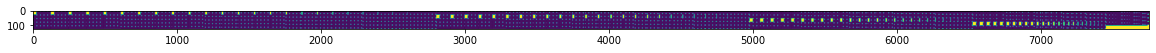

In [8]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

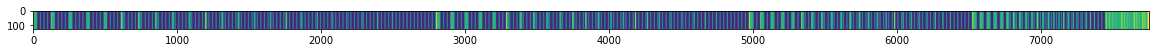

In [9]:
# all
plt.figure(figsize = figsize)
plt.imshow((xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

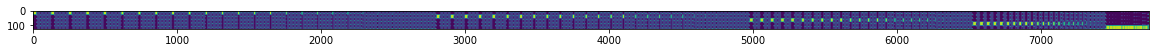

In [10]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

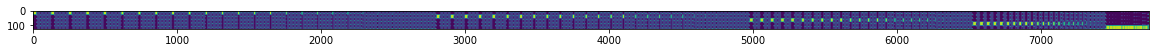

In [11]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [12]:
figsize = (20,15)
# figrange = (fx_s, fx_e, fy_s, fy_e)
figrange = (0, len(game_data['idx_to_key']), 0, 300)

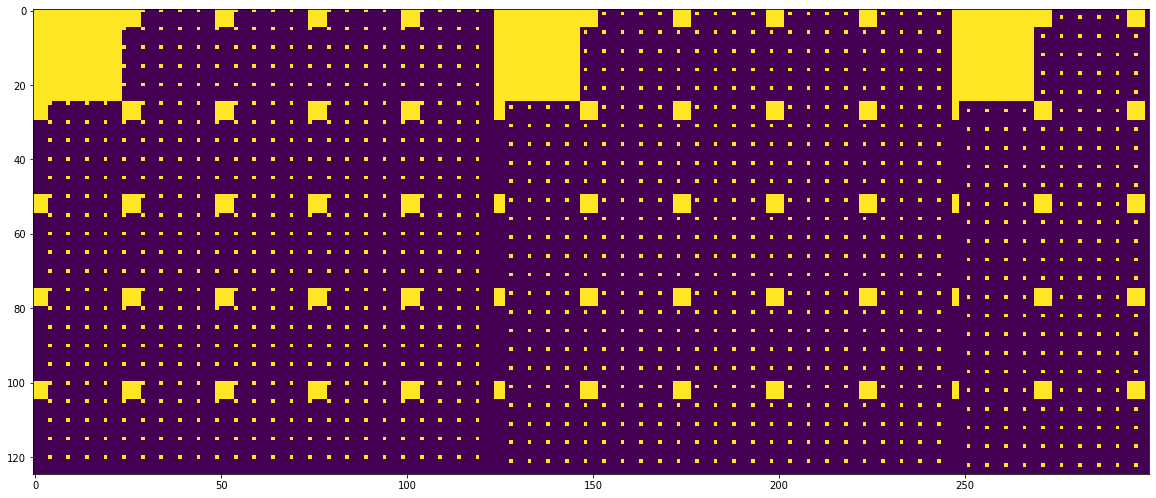

In [13]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

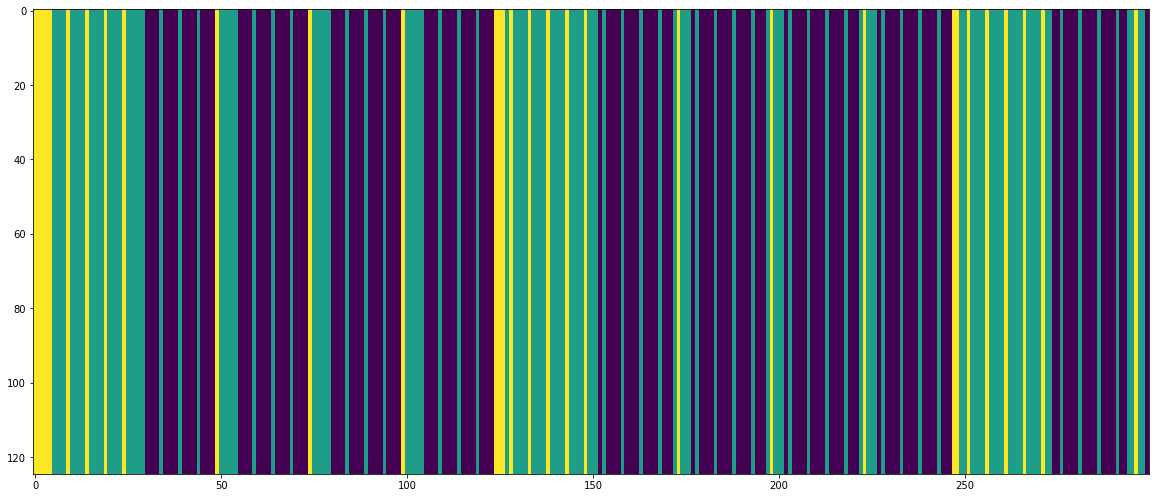

In [14]:
# all
plt.figure(figsize = figsize)
plt.imshow((xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

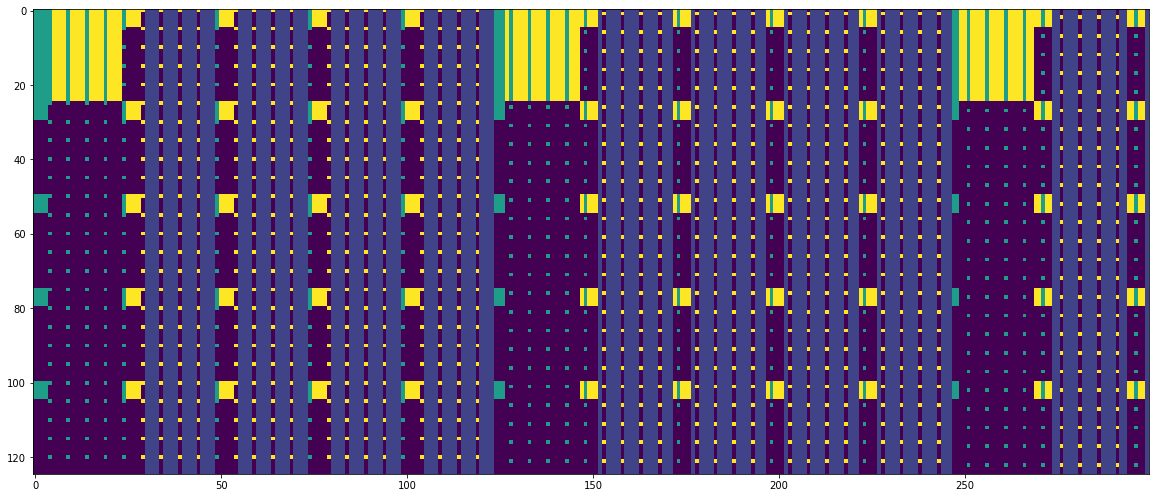

In [15]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

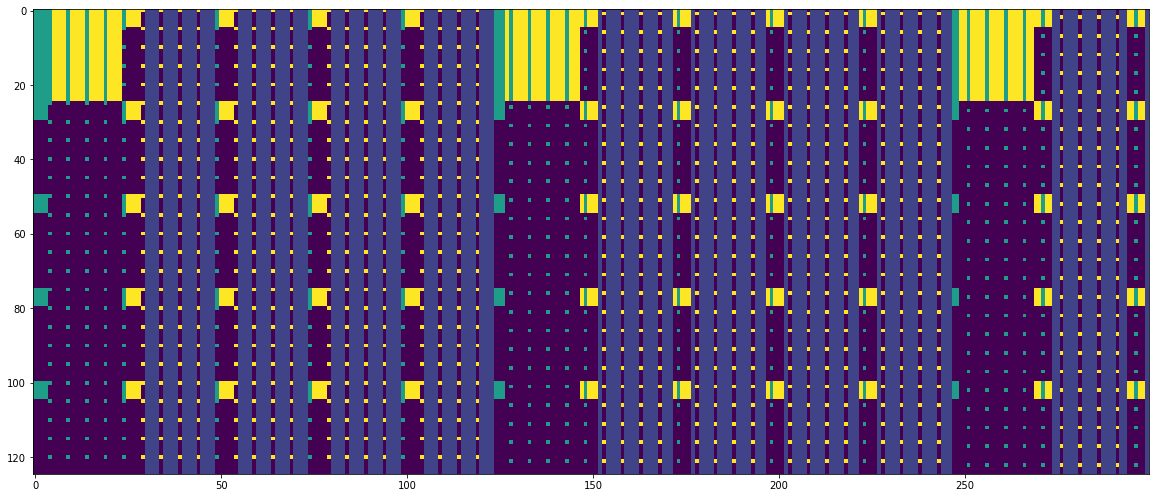

In [16]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [17]:
Counter(list((xy/xyind).reshape(-1))).most_common()

[(1.0000000000000018, 296000),
 (1.0000000000000016, 188000),
 (5.437500000000001e-95, 177600),
 (5.4375e-95, 112800),
 (5.000000000000001, 44400),
 (3.020833333333334e-95, 35520),
 (5.0, 28200),
 (3.020833333333333e-95, 24480),
 (2.7777777777777786, 19980),
 (1.0000000000000013, 16000),
 (2.7777777777777777, 12690),
 (5.437499999999999e-95, 9600),
 (4.999999999999999, 2400),
 (2.7777777777777772, 1080)]

## Dataset

In [18]:
### One embed per query!

class GameDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return self.query_support_size * self.key_support_size
    
    def __getitem__(self, idx):
        '''
        key_idx: (xy_i) * (xy.shape[1]=self.query_support_size) + (xy_j)
        '''
        x_i, y_j = idx//self.query_support_size, idx%self.query_support_size
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0
        
        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('key\n', x_i, self.raw_data['idx_to_key'][x_i])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
        
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        )    

game_dataset = GameDataset(raw_data=game_data, debug=True)
game_dataset[10] 
print('-----')
game_dataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void', 'square') ('red', 'solid', 'circle')
key
 0 ('red', 'void', 'square')
all matches 
 [('red', 'void', 'square'), ('red', 'void', 'circle'), ('red', 'void', 'triangle'), ('red', 'void', 'star'), ('red', 'void', 'hexagon'), ('red', 'dashed', 'square'), ('red', 'dashed', 'circle'), ('red', 'dashed', 'triangle'), ('red', 'dashed', 'star'), ('red', 'dashed', 'hexagon'), ('red', 'solid', 'square'), ('red', 'solid', 'circle'), ('red', 'solid', 'triangle'), ('red', 'solid', 'star'), ('red', 'solid', 'hexagon'), ('red', 'checkered', 'square'), ('red', 'checkered', 'circle'), ('red', 'checkered', 'triangle'), ('red', 'checkered', 'star'), ('red', 'checkered', 'hexagon'), ('red', 'dotted', 'square'), ('red', 'dotted', 'circle'), ('red', 'dotted', 'triangle'), ('red', 'dotted', 'star'), ('red', 'dotted', 'hexagon')]
-----
query
 7 : 0 8 ('red', 'void', 'square') ('red', 'dashed', 'star')
key
 0 ('red', 'void', 'square')
all matches 
 [('red', 'void', 'square'), ('re

(7,
 tensor([7]),
 tensor([0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]))

In [19]:
class GameTestFullDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        queries_with_shared_attr_only: bool.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return len(self.raw_data['idx_to_query'])
    
    def __getitem__(self, idx):
        '''
        key_idx: int. 0 to query_support_size-1
        '''
        y_j = idx
        x_i = torch.empty(1) # just a meaningless value
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0

        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
            
            
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        ) 
    
game_testdataset = GameTestFullDataset(raw_data=game_data, debug=True)
game_testdataset[10]
print('-----')
game_testdataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void', 'square') ('red', 'solid', 'circle')
all matches 
 [('red', 'void', 'square'), ('red', 'void', 'circle'), ('red', 'void', 'triangle'), ('red', 'void', 'star'), ('red', 'void', 'hexagon'), ('red', 'dashed', 'square'), ('red', 'dashed', 'circle'), ('red', 'dashed', 'triangle'), ('red', 'dashed', 'star'), ('red', 'dashed', 'hexagon'), ('red', 'solid', 'square'), ('red', 'solid', 'circle'), ('red', 'solid', 'triangle'), ('red', 'solid', 'star'), ('red', 'solid', 'hexagon'), ('red', 'checkered', 'square'), ('red', 'checkered', 'circle'), ('red', 'checkered', 'triangle'), ('red', 'checkered', 'star'), ('red', 'checkered', 'hexagon'), ('red', 'dotted', 'square'), ('red', 'dotted', 'circle'), ('red', 'dotted', 'triangle'), ('red', 'dotted', 'star'), ('red', 'dotted', 'hexagon')]
-----
query
 7 : 0 8 ('red', 'void', 'square') ('red', 'dashed', 'star')
all matches 
 [('red', 'void', 'square'), ('red', 'void', 'circle'), ('red', 'void', 'triangle'), ('red', 'void'

(7,
 tensor([7]),
 tensor([0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]))

In [20]:
class GameDataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size, raw_data, seen_train_xy, seen_val_xy, debug=False):
        super().__init__()
        self.batch_size = batch_size
        self.dataset = GameDataset(raw_data=raw_data, debug=debug)
#         self.testdataset = GameTestFullDataset(raw_data=raw_data, debug=debug)
        self.seen_train_xy = seen_train_xy
        self.seen_val_xy = seen_val_xy
        self.setup_samplers()
        
    def setup_samplers(self):
        self.train_sampler = WeightedRandomSampler(
            weights=self.seen_train_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        ) 
        self.val_sampler = WeightedRandomSampler(
            weights=self.seen_val_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        )
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train = self.dataset
            self.val = self.dataset
#         if stage == 'test' or stage is None:
#             self.test = self.testdataset
            
    def train_dataloader(self):
        train_loader = DataLoader(
            self.train, batch_size=self.batch_size, shuffle=False, sampler=self.train_sampler
        )
        return train_loader
    
    def val_dataloader(self):
        val_loader = DataLoader(
            self.val, batch_size=self.batch_size,  shuffle=False, sampler=self.val_sampler
        )
        return val_loader
    
#     def test_dataloader(self):
#         test_loader = DataLoader(
#             self.test, batch_size=self.batch_size, shuffle=False
#         )
#         return test_loader  

## Model Architecture

In [21]:
def construct_full_model(hparams):
    '''
    return: nn.Module.
    '''
    # embeddings
    query_embed_X = ScaledEmbedding(hparams['query_support_size'], hparams['d_model'])
    key_embed_X = ScaledEmbedding(hparams['key_support_size'], hparams['d_model'])
    embed_dropout = nn.Dropout(hparams['embed_dropout'])
    
    # full model
    model = EncoderPredictor(
        inp_query_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', query_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        inp_key_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', key_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        classifier = nn.Sequential(
            OrderedDict([   
                ('linear1', nn.Linear(2*hparams['d_model'], hparams['d_model'])),
                ('nonLinear1', nn.ReLU()),
                ('linear-out', nn.Linear(hparams['d_model'], 1)),
            ])
        ) if not hparams['dotproduct_bottleneck'] else None, 
        
        key_support_size = hparams['key_support_size'],
        d_model = hparams['d_model'],
        debug = hparams['debug'],
    )
    
    return model

In [22]:
class ScaledEmbedding(nn.Module):

    def __init__(self, V, d_model):
        super(ScaledEmbedding, self).__init__()
        self.embedding = nn.Embedding(V, d_model)
        # scale embedding to have variance 0.01
        nn.init.normal_(self.embedding.weight, mean=0., std=(0.01)**(1/2))
        self.d_model = d_model

    def forward(self, tokens):
        '''
        tokens: shape (batch_size=b, len)
        '''
        # shape (b, len, d_model)
        embedded = self.embedding(tokens) * math.sqrt(self.d_model)
        if torch.max(embedded) > 2000.:
            import pdb; pdb.set_trace()
        return embedded

In [23]:
class EncoderPredictor(nn.Module):
    
    def __init__(self, inp_query_layer, inp_key_layer, classifier, key_support_size, d_model, debug=False):
        super().__init__()
        self.inp_query_layer = inp_query_layer
        self.inp_key_layer = inp_key_layer
        self.classifier = classifier
        self.key_support_size = key_support_size
        self.d_model = d_model
        
    def forward(self, X_query, X_key, val_bool, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1) if test bool, else (b, num matched cards) or None.
        '''
        if X_key is not None: assert X_query.shape == X_key.shape
        if val_bool:
            return self.forward_norm_support(X_query, debug=debug)
        else:
            assert X_key is not None, 'X_key should not be None for normalizing over minibatch keys.'
            return self.forward_norm_minibatch(X_query, X_key, debug=debug)

    def forward_norm_minibatch(self, X_query, X_key, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)
        
        # shape(b, d_model)
        key_repr = self.encode_key(X_key).squeeze(1)
        assert key_repr.shape == (b, self.d_model)

        if self.classifier:
            raise ValueError('Not supposed to use classifier!')
            # shape(b, b, d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, b, self.d_model)
            # shape(b, b, d_model)
            key_repr_tiled = key_repr.unsqueeze(0).expand(b, b, self.d_model)
            # shape(b, b, 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            assert query_key_concat.shape == (b, b, 2*self.d_model)
            # shape(b*b, 2*d_model)
            query_key_concat = query_key_concat.reshape(b*b, 2*self.d_model)
            # shape(b*b, 1)
            logits = self.classifier(query_key_concat)
            assert logits.shape == (b*b, 1)
            # shape(b, b)
            logits = logits.squeeze(1).reshape(b, b)
        else:
            # shape(b, b) dotproduct=logit matrix
            logits = torch.matmul(query_repr, key_repr.T)
        assert logits.shape == (b, b)
        
        # shape(b, b)
        return logits

    def forward_norm_support(self, X_query, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)

        # shape(size(support), d_model)
        keys_repr = self.encode_all_keys()
        assert keys_repr.shape == (self.key_support_size, self.d_model)
        
        if self.classifier:
            # shape(b, size(support), d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), d_model)
            key_repr_tiled = keys_repr.unsqueeze(0).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            # shape(b*size(support), 2*d_model)
            query_key_concat = query_key_concat.reshape(b*self.key_support_size, 2*self.d_model)
            # shape(b*size(support), 1)
            logits = self.classifier(query_key_concat)
            # shape(b, size(support))
            logits = logits.squeeze(1).reshape(b, self.key_support_size)
        else:
            # shape(b, size(support)) dotproduct=logit matrix
            logits = torch.matmul(query_repr, keys_repr.T)
        assert logits.shape == (b, self.key_support_size)
        
        # shape(b, size(support)) 
        return logits

    def encode_query(self, X):
        '''
        X: (batch_size=b,1)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_query_layer(X)
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed     
        
    def encode_key(self, X):
        '''
        X: (batch_size=b)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_key_layer(X) 
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed  

    def encode_all_keys(self):
        
        # shape(size(support), embed_dim)
        all_embed = self.inp_key_layer.scaled_embed.embedding.weight
        assert all_embed.requires_grad == True
        assert all_embed.shape == (self.key_support_size, self.d_model)
        
        return all_embed

## Loss, Metric

In [24]:
class InfoCELoss(nn.Module):
    '''
    InfoCE Loss on a (b, b) logits matrix with Temperature scaling
    '''

    def __init__(self, temperature_const=1.0):
        super().__init__()
        self.temperature_const = temperature_const
        self.CE_loss = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, logits, debug=False):
        '''
        logits: shape (batch_size=b, b)
        '''
        assert logits.shape[0] == logits.shape[1]
        b = logits.shape[0]
        
        logits /= self.temperature_const
        
        labels = torch.arange(b).type_as(logits).long()
        sum_loss_per_row = self.CE_loss(logits, labels)
        sum_loss_per_col = self.CE_loss(logits.T, labels)
        
        if debug:
            print('sum_loss_per_row=',sum_loss_per_row)
            print('sum_loss_per_col=',sum_loss_per_col)

        loss = (sum_loss_per_row + sum_loss_per_col) * 0.5
        return loss


# ---------------------------    
loss_criterion = InfoCELoss(temperature_const=0.1)

logits = torch.tensor([
    [1.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))
print('-------------')
logits = torch.tensor([
    [3.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))


# ref
# sum_loss_per_row= tensor(20.0001)
# sum_loss_per_col= tensor(60.0001)
# avg loss= tensor(40.0001)
# -------------
# sum_loss_per_row= tensor(0.6933)
# sum_loss_per_col= tensor(40.0001)
# avg loss= tensor(20.3467)

sum_loss_per_row= tensor(20.0001)
sum_loss_per_col= tensor(60.0001)
avg loss= tensor(40.0001)
-------------
sum_loss_per_row= tensor(0.6933)
sum_loss_per_col= tensor(40.0001)
avg loss= tensor(20.3467)


In [25]:
class ThresholdedMetrics(nn.Module):
    
    def __init__(self, raw_data):
        '''
        tot_k: total number of candidates. e.g. 81 cards
        '''
        super().__init__()
        self.raw_data = raw_data
        self.key_support_size = len(self.raw_data['idx_to_key'])
        self.threshold = 1.0 / (self.key_support_size)
        self.softmax = nn.Softmax(dim=1)

    def breakdown_errors(self, X_query, corrects):
        '''
        X_query: shape (b,1) (if one embed per query)
        corrects: shape (b, support size)
        '''
        b = X_query.shape[0]
        assert corrects.shape == (b, self.key_support_size)
        
        X_query_list = X_query.squeeze(-1)
        wrongs = (1 - corrects).cpu().numpy()
        
        num_matched_concepts = [
             self.raw_data['query_to_keys'].get(X_query_list[batch_i].item(), {}).get(card_idx, 0)
            for batch_i in range(b) for card_idx in range(self.key_support_size)  
        ]
        
        num_matched_concepts = np.array(num_matched_concepts).reshape(b, self.key_support_size)
        assert num_matched_concepts.shape == wrongs.shape
        
        wrongs_mask = wrongs.reshape(-1).tolist()
        num_matched_concepts = num_matched_concepts.reshape(-1).tolist()

        error_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        total_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        for w,k in zip(wrongs_mask, num_matched_concepts):
            if w == 1:
                error_count_by_num_matched_concepts[k] += 1
            total_count_by_num_matched_concepts[k] += 1    

        error_counts, total_counts = {}, {}
        for k in range(num_attributes):
            err_ct = error_count_by_num_matched_concepts[k]
            tot_ct = total_count_by_num_matched_concepts[k]
            error_counts[f'error_rate_for_{k}_matched_concepts'] = 0 if tot_ct == 0 else (err_ct *1.0 / tot_ct)
            total_counts[f'total_count_for_{k}_matched_concepts'] = tot_ct

        return {**error_counts, **total_counts}    
    
    def forward(self, X_query, logits, X_keys, full_test_bool=False, breakdown_errors_bool=False, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        b, key_support_size = logits.shape
        assert key_support_size == self.key_support_size
        assert logits.shape == X_keys.shape
        
        if full_test_bool:
            # filter down to query cards with >0 true matches
            queryIdxs_with_nonzero_matches = list(self.raw_data['query_to_keys'].keys())
            X_query_flat = X_query.squeeze(-1)
            fil = torch.stack([(X_query_flat == qId) for qId in queryIdxs_with_nonzero_matches], dim=1).any(dim=1)
            assert fil.shape == (b, )
            
            # queries with shared attributes
            fil_metrics = self.compute_metrics(X_query[fil], logits[fil], X_keys[fil], breakdown_errors_bool, debug)
            fil_metrics = {'nonNullQueries_'+k:fil_metrics[k] for k in fil_metrics}
            
            # queries without shared attributes
            not_fil = torch.logical_not(fil)
            not_fil_metrics = self.compute_metrics(X_query[not_fil], logits[not_fil], X_keys[not_fil], breakdown_errors_bool, debug)
            not_fil_metrics = {'NullQueries_'+k:not_fil_metrics[k] for k in not_fil_metrics}
            
            # all queries
            all_metrics = self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
            
            return {**fil_metrics, **not_fil_metrics, **all_metrics}
        else:
            return self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
    
    def compute_metrics(self, X_query, logits, X_keys, breakdown_errors_bool=False, debug=False):
        '''
        X_query: shape (b,1) (if one embed per query)
        logits: shape (b, support size)
        X_keys: shape (b, support size). value 1.0 at where card matches. value 0 otherwise.
        '''
        b, key_support_size = logits.shape
        
        # model predictions, shape (b, support size)
        binary_predictions = (self.softmax(logits) >= self.threshold).type(torch.float)
        # ground truth, shape (b, support size)
        gt = X_keys
        # correct predictions, shape (b, support size)
        corrects = (binary_predictions == gt).type(torch.float)
        
        # accuracy, computed per query, average across queries
        # (b,)
        accuracy_row = torch.sum(corrects, dim=1) / key_support_size
        # scalar
        accuracy_meanrows = torch.mean(accuracy_row)
        # accuracy, computed per query-key, average across all
        accuracy_all = torch.sum(corrects) / (b * key_support_size)
        
        # precision, computed per query, average across queries
        # (b,)
        precision_row = torch.sum((corrects * binary_predictions), dim=1) / torch.sum(binary_predictions, dim=1)
        # scalar
        precision_meanrows = torch.mean(precision_row)
        # precision, computed per query-key, average across all
        precision_all = torch.sum((corrects * binary_predictions)) / torch.sum(binary_predictions)

        # recall, computed per query, average across queries
        # (b,)
        recall_row = torch.sum((corrects * gt), dim=1) / torch.sum(gt, dim=1)
        # scalar
        recall_meanrows = torch.mean(recall_row)
        # recall, computed per query-key, average across all
        recall_all = torch.sum((corrects * gt)) / torch.sum(gt)
        
        # f1, computed per query, average across queries
        # (b,)
        f1_row = 2 * (precision_row * recall_row) / (precision_row + recall_row)
        # scalar
        f1_meanrows = torch.mean(f1_row)
        # f1, computed per query-key, average across all
        f1_all = (precision_all * recall_all) / (precision_all + recall_all)
        
        if breakdown_errors_bool:
            error_breakdown_by_num_matched_concepts = self.breakdown_errors(X_query, corrects)
        else:
            error_breakdown_by_num_matched_concepts = {} 
            
        if debug:
            print('####################################################')
            print('Metrics Per Query:')
            print('accuracy_rows', accuracy_row)
            print('precision_row', precision_row)
            print('recall_row', recall_row)
            print('f1_row', f1_row)
            print('####################################################')
            print('Metrics Averaged Across Queries')
            print('accuracy_meanrows', accuracy_meanrows)
            print('precision_meanrows', precision_meanrows)
            print('recall_meanrows', recall_meanrows)
            print('f1_meanrows', f1_meanrows)
            print('####################################################')
            print('Metrics Averaged Across All Query-Key Pairs:')
            print('accuracy_all', accuracy_all)
            print('precision_all', precision_all)
            print('recall_all', recall_all)
            print('f1_all', f1_all)
            print('####################################################')
            print('error_breakdown', error_breakdown_by_num_matched_concepts)
            
        metrics = {
            'accuracy_by_Query': accuracy_meanrows,
            'precision_by_Query': precision_meanrows,
            'recall_by_Query': recall_meanrows,
            'f1_by_Query': f1_meanrows,
            'accuracy_by_QueryKey': accuracy_all,
            'precision_by_QueryKey': precision_all,
            'recall_by_QueryKey': recall_all,
            'f1_by_QueryKey': f1_all
        }
        metrics = {
            **metrics, **error_breakdown_by_num_matched_concepts
        }
        return metrics


def test_metric_module():
    key_support_size=3
    thresh=1./key_support_size

    m_f = ThresholdedMetrics(raw_data=game_data)
    m_f.key_support_size = 3

    logits = torch.tensor(
        [
            [thresh, thresh, thresh],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    print('----------------------------------------------')
    
    logits = torch.tensor(
        [
            [0.4, 0.2, 0.4],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    
    
# test_metric_module()

# reference output
# accuracy_row tensor([0.3333, 0.3333, 1.0000])
# precision_row tensor([0.3333, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.5000, 0.5000, 1.0000])
# {'accuracy': tensor(0.5556), 'precision': tensor(0.5556), 'recall': tensor(1.), 'f1': tensor(0.6667)}
# ----------------------------------------------
# accuracy_row tensor([0.6667, 0.3333, 1.0000])
# precision_row tensor([0.5000, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.6667, 0.5000, 1.0000])
# {'accuracy': tensor(0.6667), 'precision': tensor(0.6111), 'recall': tensor(1.), 'f1': tensor(0.7222)}

## Training Module

In [26]:
# Build Lightning Module
# https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31#scrollTo=UIXLW8CO-W8w

thresholded_metrics = ThresholdedMetrics(raw_data=game_data)

class TrainModule(pl.LightningModule):
    
    def __init__(self, hparams, gt_distributions):
        '''
        hparams: dictionary of hyperparams
        gt_distributions: dictionary that stores the groundtruth 'xy', 'xyind' distributions.
                         each is a key_support_size by query_support_size matrix that sums up to 1.0
        '''
        super().__init__()
        self.hparams = hparams
        self.debug = hparams['debug']
        self.save_hyperparameters()
        
        self.model = construct_full_model(hparams)
        self.loss_criterion = InfoCELoss(temperature_const=self.hparams['loss_temperature_const'])
        self.metrics = thresholded_metrics

        self.key_support_size = self.hparams['key_support_size']
        self.query_support_size = self.hparams['query_support_size']
        
        # for pulling model p(x,y) and p(x,y)/[pxpy]
        self.populate_logits_matrix = hparams['populate_logits_matrix']
        if self.populate_logits_matrix:
            self.register_buffer(
                name='model_logits_matrix',
                tensor= torch.zeros(hparams['key_support_size'], hparams['query_support_size'])
            )
            self.setup_gt_distributions(gt_distributions)
        
    def log_metrics(self, metrics_dict):
        for k, v in metrics_dict.items():
            self.log(k, v)
            
    def get_max_memory_alloc(self):
        devices_max_memory_alloc = {}
        for i in range(torch.cuda.device_count()):
            device = torch.device(f'cuda:{i}')
            devices_max_memory_alloc[device] = torch.cuda.max_memory_allocated(device) / 1e6
            torch.cuda.reset_max_memory_allocated(device)
        return devices_max_memory_alloc
    
    ###################################################
    
    def forward(self, X_query, X_key, X_keys, val_bool, full_test_bool=False, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1)
        X_keys: (b, key_support_size) 1s and 0s.
        test_bool: boolean.
        '''
        batch_size = X_query.shape[0]
        
        # ToDo batch_size_b
        
        # shape (b,support) if test_bool else (b, b)
        logits = self.model(X_query, X_key, val_bool, debug=debug)
        # scalar
        loss = None if val_bool else self.loss_criterion(logits, debug=debug)
        # scalar
        metrics = self.metrics(
            logits=logits, X_keys=X_keys, X_query=X_query, 
            debug=debug, full_test_bool=full_test_bool, breakdown_errors_bool=True, 
        ) if val_bool else None

        return logits, loss, metrics
    
    ###################################################
    
    def setup_gt_distributions(self, gt_distributions):
        '''called once during init to setup groundtruth distributions'''
        assert gt_distributions['xy'].shape == gt_distributions['xyind'].shape
        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy',
            tensor= torch.tensor(gt_distributions['xy'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xyind',
            tensor= torch.tensor(gt_distributions['xyind'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy_div_xyind',
            tensor= self.gt_xy/self.gt_xyind
        )
        # scalar
        self.register_buffer(
            name='one',
            tensor= torch.tensor([1.0])
        )   
        # scalar
        self.register_buffer(
            name='gt_mi',
            tensor= self.compute_mutual_information(self.gt_xy, self.gt_xy_div_xyind)
        ) 
   
    
    def populate_model_logits_matrix(self, query_idx, logits):
        '''
        query_idx: shape (b,)
        logits: shape(b, key_support_size)
        '''  
        assert query_idx.shape[0] == logits.shape[0]
        b = query_idx.shape[0]
        assert logits.shape[1] == self.key_support_size
        for i in range(b):
            self.model_logits_matrix[:,query_idx[i]] = logits[i]
    
    def compute_mutual_information(self, xy, xy_div_xyind):
        '''
        xy: p(xy). shape(b, key_support_size)
        xy_div_xyind_hat: p(xy)/[p(x)(y)].
                          shape(b, key_support_size)
        '''
        assert torch.isclose(torch.sum(xy), self.one.type_as(xy))
        assert xy.shape == xy_div_xyind.shape == (
            self.key_support_size, self.query_support_size
        )
        pmi = torch.log(xy_div_xyind)
        mi = torch.sum(xy * pmi)
        return mi
    
    def pull_model_distribution(self, debug=True):

        # sanity check
        sum_logits = torch.sum(self.model_logits_matrix)
        assert sum_logits != 0.0
        
        if debug:
            print('Sum of model logits matrix\n', sum_logits)
            print('Number of model logits with zero value\n', torch.sum(self.model_logits_matrix == 0.0)) 
            print('Variance of model logits\n', torch.var(self.model_logits_matrix))
        
        # estimate the full distribution
        # hat( k * pxy/(pxpy)
        f = torch.exp(self.model_logits_matrix)
        # hat( k * pxy)
        xy_hat = f * self.gt_xyind
        # hat( pxy)
        xy_hat = (xy_hat / torch.sum(xy_hat))
        
        # estimate exp(pmi)
        # hat(k)
        k_hat = torch.sum(f) / torch.sum(self.gt_xy_div_xyind)
        # hat(pxy/(pxpy)
        xy_div_xyind_hat = (f / k_hat)
        if torch.any(torch.isnan(xy_div_xyind_hat)):
            import pdb; pdb.set_trace()
        
        # estimate MI
        # scalar
        mi_hat = self.compute_mutual_information(xy_hat, xy_div_xyind_hat)
        # scalar
        mi_gt_minus_hat = self.gt_mi - mi_hat
        
        # estimate KL divergence
        kl_div_val = F.kl_div(torch.log(xy_hat), self.gt_xy)

        # estimate ranks
        xy_hat = xy_hat.detach().cpu().numpy()
        xy_div_xyind_hat = xy_div_xyind_hat.detach().cpu().numpy()
        # hat(pxy rank)
        xy_hat_rank = np.linalg.matrix_rank(xy_hat)
        # hat(pxy/(pxpy rank)
        xy_div_xyind_hat_rank = np.linalg.matrix_rank(xy_div_xyind_hat) 
        
        pulled_distribution_results = {
            'xy_hat':xy_hat,
            'xy_div_xyind_hat':xy_div_xyind_hat,
            'xy_hat_rank':xy_hat_rank,
            'xy_div_xyind_hat_rank':xy_div_xyind_hat_rank,
            'mi_hat':mi_hat,
            'mi_gt_minus_hat':mi_gt_minus_hat,
            'kl_div':kl_div_val
        }
        
        return pulled_distribution_results

    ###################################################
    
    def training_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        # scalar
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        # dict
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('train step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\nX_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:\n', [(m,metrics[m]) for m in metrics]
            )
        
        # log
        step_metrics = {**{'train_loss': loss}, **{'train_'+m:metrics[m] for m in metrics}}
        self.log_metrics(step_metrics)
        return loss
    
    def validation_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('validation step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\X_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:', [(m,metrics[m]) for m in metrics]
            )
            
        # log 
        step_metrics = {**{'val_loss': loss}, **{'val_'+m:metrics[m] for m in metrics}}
        devices_max_memory_alloc = self.get_max_memory_alloc()
        for device, val in devices_max_memory_alloc.items():
            step_metrics[f'step_max_memory_alloc_cuda:{device}'] = val
        self.log_metrics(step_metrics)
        return step_metrics
    
    def test_step(self, batch, batch_nb):
        
        # (b,1), (b,1), _, (b, support size)
        query_idx, X_query, _, X_keys = batch
        
        # compute scores for all keys
        # shape(b, key_support_size), _, dictionary
        logits, _, metrics = self(X_query, None, X_keys, val_bool=True, full_test_bool=True, debug=self.debug)
        
        if self.populate_logits_matrix:
            self.populate_model_logits_matrix(query_idx, logits)
        
        # log
        step_metrics = {'test_'+m:metrics[m] for m in metrics}
        self.log_metrics(step_metrics)
        return step_metrics 
    
    ###################################################
    
    def aggregate_metrics_at_epoch_end(self, outputs):
        # log metrics
        epoch_metrics = {}
        metric_names = outputs[0].keys()
        for m in metric_names:
            if not ('max_memory_alloc_cuda' in m or 'count' in m or 'rate' in m):
                epoch_metrics['avg_'+m] = torch.stack([x[m] for x in outputs]).mean()
            elif '_matched_concepts' in m:
                epoch_metrics['avg_'+m] = np.mean([x[m] for x in outputs])
        self.log_metrics(epoch_metrics)
        return epoch_metrics         
    
    def validation_epoch_end(self, outputs):
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        return averaged_metrics
    
    def test_epoch_end(self, outputs):        
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        try:
            assert 'avg_test_error_rate_for_1_matched_concepts' in averaged_metrics
        except:
            import pdb; pdb.set_trace()
            
        return averaged_metrics
    
    ###################################################
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(
            params=self.model.parameters(),
            lr=self.hparams['lr'],
            betas=(
                self.hparams['adam_beta1'], self.hparams['adam_beta2']),
            eps=self.hparams['adam_epsilon'],
            weight_decay=self.hparams['adam_weight_decay']
        )
        return opt

## hparams, init train module

In [27]:
# W&B References
# https://docs.wandb.com/library/integrations/lightning
# colab example
# https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Supercharge_your_Training_with_Pytorch_Lightning_%2B_Weights_%26_Biases.ipynb
# step by step guide
# https://wandb.ai/cayush/pytorchlightning/reports/Use-Pytorch-Lightning-with-Weights-Biases--Vmlldzo2NjQ1Mw


# Distributed Weighted Sampler
# https://discuss.pytorch.org/t/how-to-use-my-own-sampler-when-i-already-use-distributedsampler/62143/8
# https://github.com/PyTorchLightning/pytorch-lightning/discussions/3716#discussioncomment-238296

# torch lightning -- how sampler is added or removed
# https://pytorch-lightning.readthedocs.io/en/stable/multi_gpu.html?highlight=sampler#remove-samplers


hparams = {
    # game difficulty
    'num_attributes': num_attributes,
    'num_attr_vals': num_attr_vals,
    # distribution
    'distribution_epsilon': distribution_epsilon,
    'xy_size': xy.shape,
    # 
    'batch_size': 128,
    # Arch
    'key_support_size': len(game_data['idx_to_key']),
    'query_support_size': len(game_data['idx_to_query']),
    # embedding
    'd_model': 32,
    'embed_dropout': 0.0,
    # final prediction
    'dotproduct_bottleneck':True,
    # loss
    'loss_temperature_const': 1.0,
    # optimizer
    'lr': 0.001,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'adam_epsilon': 1e-08,
    'warmup_steps': 12000,
    'adam_weight_decay':0,
    'gradient_clip_val': 0,
    # others
    'debug':False,
    'populate_logits_matrix': True
}

pl.seed_everything(42)

# model
trainmodule =  TrainModule(hparams, gt_distributions={'xy':xy, 'xyind':xyind})# , raw_data=game_data)
model_summary = pl.core.memory.ModelSummary(trainmodule, mode='full')
print(model_summary,'\n')

# data
game_datamodule = GameDataModule(
    batch_size = hparams['batch_size'],
    raw_data = game_data,
    seen_train_xy = xy,
    seen_val_xy = xy,
    debug=hparams['debug']
)

# logger
run_name = 'CardGame:OR;attr{}-val{};epsilon{};d_model{};params{}K;dot-product'.format(num_attributes, num_attr_vals, str(distribution_epsilon), hparams['d_model'], round(max(model_summary.param_nums)/1000,2))
project_name = 'ContrastiveLearning-cardgame-Scaling'
wd_logger = WandbLogger(name=run_name, project=project_name)
print('RUN NAME :\n', run_name)
# check point path
ckpt_dir_PATH = os.path.join('checkpoints', project_name, run_name)

Global seed set to 42


   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 252 K 
1  | model.inp_query_layer                        | Sequential         | 248 K 
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 248 K 
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 248 K 
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 4.0 K 
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 4.0 K 
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 4.0 K 
8  | loss_criterion                               | InfoCELoss         | 0     
9  | loss_criterion.CE_loss                       | CrossEntropyLoss   | 0     
10 | metrics                      

## Run Training

In [28]:
# checkpoints
os.makedirs(ckpt_dir_PATH, exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    monitor='avg_val_accuracy_by_Query',
    dirpath=ckpt_dir_PATH,
    filename='{epoch:02d}-{val_loss:.2f}',
    save_top_k=6,
    save_last=True,
    mode='max',
)

# trainer
trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=50000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

#fit
with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
<ipython-input-28-49cb5c6af813>:26: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


wandb: WARNING Serializing object of type ndarray that is 7750112 bytes
wandb: WARNING Serializing object of type ndarray that is 7750112 bytes

   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 252 K 
1  | model.inp_query_layer                        | Sequential         | 248 K 
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 248 K 
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 248 K 
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 4.0 K 
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 4.0 K 
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 4.0 K 
8  | loss_criterion                              

Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                        

/home/user/miniconda/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  1.71it/s, loss=849, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=827, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=844, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=837, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  2.74it/s, loss=831, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=826, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=829, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  3.10it/s, loss=823, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=822, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9:  50%|█████     | 1/

Epoch 34:  50%|█████     | 1/2 [00:00<00:00,  2.77it/s, loss=800, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 35:  50%|█████     | 1/2 [00:00<00:00,  3.14it/s, loss=797, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 36:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=795, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 37:  50%|█████     | 1/2 [00:00<00:00,  3.08it/s, loss=793, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 38:  50%|█████     | 1/2 [00:00<00:00,  3.26it/s, loss=793, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 39:  50%|█████     | 1/2 [00:00<00:00,  3.12it/s, loss=793, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 40:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=792, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 41:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=791, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 42:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=788, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 43:  50%|████

Validating: 0it [00:00, ?it/s]
Epoch 68:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=768, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 69:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=768, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 70:  50%|█████     | 1/2 [00:00<00:00,  3.03it/s, loss=766, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 71:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=767, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 72:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=767, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 73:  50%|█████     | 1/2 [00:00<00:00,  2.89it/s, loss=766, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 74:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=765, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 75:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=766, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 76:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=763, v_num=5qvg]
Validating: 0it [00

Epoch 101:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=742, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 102:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=741, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 103:  50%|█████     | 1/2 [00:00<00:00,  2.91it/s, loss=741, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 104:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=739, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 105:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=739, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 106:  50%|█████     | 1/2 [00:00<00:00,  2.74it/s, loss=739, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 107:  50%|█████     | 1/2 [00:00<00:00,  2.66it/s, loss=736, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 108:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=737, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 109:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=736, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 110:

Validating: 0it [00:00, ?it/s]
Epoch 135:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=719, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 136:  50%|█████     | 1/2 [00:00<00:00,  3.01it/s, loss=719, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 137:  50%|█████     | 1/2 [00:00<00:00,  1.98it/s, loss=719, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 138:  50%|█████     | 1/2 [00:00<00:00,  3.01it/s, loss=718, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 139:  50%|█████     | 1/2 [00:00<00:00,  2.01it/s, loss=718, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 140:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=717, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 141:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=715, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 142:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=715, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 143:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=717, v_num=5qvg]
Validating

Epoch 168:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=698, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 169:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=697, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 170:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=697, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 171:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=697, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 172:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=697, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 173:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=697, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 174:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=697, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 175:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=695, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 176:  50%|█████     | 1/2 [00:00<00:00,  3.21it/s, loss=693, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 177:

Epoch 201:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=689, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 202:  50%|█████     | 1/2 [00:00<00:00,  3.07it/s, loss=687, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 203:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=686, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 204:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=686, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 205:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=686, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 206:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=685, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 207:  50%|█████     | 1/2 [00:00<00:00,  3.50it/s, loss=685, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 208:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=684, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 209:  50%|█████     | 1/2 [00:00<00:00,  2.17it/s, loss=683, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 210:

Validating: 0it [00:00, ?it/s]
Epoch 235:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=675, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 236:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=677, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 237:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=678, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 238:  50%|█████     | 1/2 [00:00<00:00,  3.13it/s, loss=678, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 239:  50%|█████     | 1/2 [00:00<00:00,  3.43it/s, loss=678, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 240:  50%|█████     | 1/2 [00:00<00:00,  3.33it/s, loss=678, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 241:  50%|█████     | 1/2 [00:00<00:00,  3.33it/s, loss=678, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 242:  50%|█████     | 1/2 [00:00<00:00,  2.96it/s, loss=677, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 243:  50%|█████     | 1/2 [00:00<00:00,  3.13it/s, loss=677, v_num=5qvg]
Validating

Epoch 268:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=667, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 269:  50%|█████     | 1/2 [00:00<00:00,  2.90it/s, loss=667, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 270:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=667, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 271:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=668, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 272:  50%|█████     | 1/2 [00:00<00:00,  2.95it/s, loss=668, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 273:  50%|█████     | 1/2 [00:00<00:00,  3.43it/s, loss=668, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 274:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=668, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 275:  50%|█████     | 1/2 [00:00<00:00,  3.24it/s, loss=668, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 276:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=667, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 277:

Epoch 301:  50%|█████     | 1/2 [00:00<00:00,  3.12it/s, loss=657, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 302:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=656, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 303:  50%|█████     | 1/2 [00:00<00:00,  2.63it/s, loss=656, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 304:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=656, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 305:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=656, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 306:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=656, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 307:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=655, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 308:  50%|█████     | 1/2 [00:00<00:00,  2.92it/s, loss=654, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 309:  50%|█████     | 1/2 [00:00<00:00,  3.50it/s, loss=654, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 310:

Validating: 0it [00:00, ?it/s]
Epoch 335:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=654, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 336:  50%|█████     | 1/2 [00:00<00:00,  2.58it/s, loss=653, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 337:  50%|█████     | 1/2 [00:00<00:00,  2.78it/s, loss=653, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 338:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=653, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 339:  50%|█████     | 1/2 [00:00<00:00,  2.73it/s, loss=652, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 340:  50%|█████     | 1/2 [00:00<00:00,  2.69it/s, loss=652, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 341:  50%|█████     | 1/2 [00:00<00:00,  3.04it/s, loss=652, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 342:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=652, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 343:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=652, v_num=5qvg]
Validating

Epoch 368:  50%|█████     | 1/2 [00:00<00:00,  3.24it/s, loss=643, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 369:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=644, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 370:  50%|█████     | 1/2 [00:00<00:00,  3.35it/s, loss=644, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 371:  50%|█████     | 1/2 [00:00<00:00,  2.99it/s, loss=644, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 372:  50%|█████     | 1/2 [00:00<00:00,  3.09it/s, loss=644, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 373:  50%|█████     | 1/2 [00:00<00:00,  3.13it/s, loss=644, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 374:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=644, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 375:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=643, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 376:  50%|█████     | 1/2 [00:00<00:00,  3.35it/s, loss=644, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 377:

Epoch 401:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=639, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 402:  50%|█████     | 1/2 [00:00<00:00,  2.64it/s, loss=640, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 403:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=640, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 404:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=641, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 405:  50%|█████     | 1/2 [00:00<00:00,  2.92it/s, loss=641, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 406:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=641, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 407:  50%|█████     | 1/2 [00:00<00:00,  2.69it/s, loss=641, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 408:  50%|█████     | 1/2 [00:00<00:00,  3.26it/s, loss=640, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 409:  50%|█████     | 1/2 [00:00<00:00,  2.55it/s, loss=640, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 410:

Validating: 0it [00:00, ?it/s]
Epoch 435:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=635, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 436:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=636, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 437:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=636, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 438:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=636, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 439:  50%|█████     | 1/2 [00:00<00:00,  3.02it/s, loss=636, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 440:  50%|█████     | 1/2 [00:00<00:00,  2.97it/s, loss=635, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 441:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=634, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 442:  50%|█████     | 1/2 [00:00<00:00,  3.33it/s, loss=635, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 443:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=635, v_num=5qvg]
Validating

Epoch 468:  50%|█████     | 1/2 [00:00<00:00,  2.92it/s, loss=633, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 469:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=633, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 470:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=632, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 471:  50%|█████     | 1/2 [00:00<00:00,  3.11it/s, loss=632, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 472:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=633, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 473:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=633, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 474:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=633, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 475:  50%|█████     | 1/2 [00:00<00:00,  2.60it/s, loss=632, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 476:  50%|█████     | 1/2 [00:00<00:00,  2.74it/s, loss=631, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 477:

Epoch 501:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=625, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 502:  50%|█████     | 1/2 [00:00<00:00,  3.02it/s, loss=625, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 503:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=624, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 504:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=625, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 505:  50%|█████     | 1/2 [00:00<00:00,  2.58it/s, loss=625, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 506:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=624, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 507:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=624, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 508:  50%|█████     | 1/2 [00:00<00:00,  3.42it/s, loss=624, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 509:  50%|█████     | 1/2 [00:00<00:00,  2.03it/s, loss=624, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 510:

Validating: 0it [00:00, ?it/s]
Epoch 535:  50%|█████     | 1/2 [00:00<00:00,  3.33it/s, loss=624, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 536:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=624, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 537:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=624, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 538:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=624, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 539:  50%|█████     | 1/2 [00:00<00:00,  3.06it/s, loss=624, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 540:  50%|█████     | 1/2 [00:00<00:00,  2.51it/s, loss=624, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 541:  50%|█████     | 1/2 [00:00<00:00,  3.04it/s, loss=624, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 542:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=625, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 543:  50%|█████     | 1/2 [00:00<00:00,  3.22it/s, loss=625, v_num=5qvg]
Validating

Epoch 568:  50%|█████     | 1/2 [00:00<00:00,  3.19it/s, loss=622, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 569:  50%|█████     | 1/2 [00:00<00:00,  2.88it/s, loss=621, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 570:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=621, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 571:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=621, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 572:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=621, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 573:  50%|█████     | 1/2 [00:00<00:00,  1.81it/s, loss=620, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 574:  50%|█████     | 1/2 [00:00<00:00,  2.18it/s, loss=621, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 575:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=620, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 576:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=620, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 577:

Epoch 601:  50%|█████     | 1/2 [00:00<00:00,  2.05it/s, loss=618, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 602:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=617, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 603:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=617, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 604:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=617, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 605:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=616, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 606:  50%|█████     | 1/2 [00:00<00:00,  2.58it/s, loss=616, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 607:  50%|█████     | 1/2 [00:00<00:00,  3.30it/s, loss=616, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 608:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=616, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 609:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=616, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 610:

Validating: 0it [00:00, ?it/s]
Epoch 635:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=612, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 636:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=612, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 637:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=612, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 638:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=612, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 639:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=612, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 640:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=612, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 641:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=612, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 642:  50%|█████     | 1/2 [00:00<00:00,  3.03it/s, loss=611, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 643:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=612, v_num=5qvg]
Validating

Epoch 668:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=611, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 669:  50%|█████     | 1/2 [00:00<00:00,  2.88it/s, loss=611, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 670:  50%|█████     | 1/2 [00:00<00:00,  3.19it/s, loss=611, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 671:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=611, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 672:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=611, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 673:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=610, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 674:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=610, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 675:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=610, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 676:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=610, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 677:

Epoch 701:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=609, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 702:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=610, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 703:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=609, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 704:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=609, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 705:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=609, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 706:  50%|█████     | 1/2 [00:00<00:00,  2.93it/s, loss=609, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 707:  50%|█████     | 1/2 [00:00<00:00,  3.50it/s, loss=608, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 708:  50%|█████     | 1/2 [00:00<00:00,  3.07it/s, loss=607, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 709:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=607, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 710:

Validating: 0it [00:00, ?it/s]
Epoch 735:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=605, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 736:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=604, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 737:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=604, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 738:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=604, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 739:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=603, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 740:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=603, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 741:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=603, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 742:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=603, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 743:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=603, v_num=5qvg]
Validating

Epoch 768:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=601, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 769:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=600, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 770:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=600, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 771:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=600, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 772:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=599, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 773:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=599, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 774:  50%|█████     | 1/2 [00:00<00:00,  3.19it/s, loss=599, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 775:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=599, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 776:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=599, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 777:

Epoch 801:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=598, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 802:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=599, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 803:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=598, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 804:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=598, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 805:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=598, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 806:  50%|█████     | 1/2 [00:00<00:00,  2.50it/s, loss=597, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 807:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=597, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 808:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=597, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 809:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=596, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 810:

Validating: 0it [00:00, ?it/s]
Epoch 835:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=591, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 836:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=591, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 837:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=591, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 838:  50%|█████     | 1/2 [00:00<00:00,  3.02it/s, loss=591, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 839:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=592, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 840:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=591, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 841:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=592, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 842:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=591, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 843:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=591, v_num=5qvg]
Validating

Epoch 868:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=591, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 869:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=591, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 870:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=591, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 871:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=591, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 872:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=591, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 873:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=592, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 874:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=591, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 875:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=590, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 876:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=590, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 877:

Epoch 901:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=584, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 902:  50%|█████     | 1/2 [00:00<00:00,  3.42it/s, loss=584, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 903:  50%|█████     | 1/2 [00:00<00:00,  2.54it/s, loss=583, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 904:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=584, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 905:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=584, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 906:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=583, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 907:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=584, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 908:  50%|█████     | 1/2 [00:00<00:00,  3.06it/s, loss=584, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 909:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=585, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 910:

Validating: 0it [00:00, ?it/s]
Epoch 935:  50%|█████     | 1/2 [00:00<00:00,  3.14it/s, loss=581, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 936:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=581, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 937:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=580, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 938:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=580, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 939:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=580, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 940:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=579, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 941:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=580, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 942:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=579, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 943:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=579, v_num=5qvg]
Validating

Epoch 968:  50%|█████     | 1/2 [00:00<00:00,  3.32it/s, loss=576, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 969:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=575, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 970:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=575, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 971:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=575, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 972:  50%|█████     | 1/2 [00:00<00:00,  3.26it/s, loss=574, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 973:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=574, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 974:  50%|█████     | 1/2 [00:00<00:00,  2.71it/s, loss=574, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 975:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=574, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 976:  50%|█████     | 1/2 [00:00<00:00,  3.38it/s, loss=573, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 977:

Epoch 1001:  50%|█████     | 1/2 [00:00<00:00,  3.38it/s, loss=573, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1002:  50%|█████     | 1/2 [00:00<00:00,  2.92it/s, loss=573, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1003:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=572, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1004:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=572, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1005:  50%|█████     | 1/2 [00:00<00:00,  3.33it/s, loss=572, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1006:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=572, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1007:  50%|█████     | 1/2 [00:00<00:00,  2.69it/s, loss=572, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1008:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=572, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1009:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=571, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1034:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=567, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1035:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=566, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1036:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=565, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1037:  50%|█████     | 1/2 [00:00<00:00,  2.92it/s, loss=565, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1038:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=565, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1039:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=565, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1040:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=564, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1041:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=564, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1042:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=564, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1067:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=561, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1068:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=560, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1069:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=561, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1070:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=562, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1071:  50%|█████     | 1/2 [00:00<00:00,  2.12it/s, loss=562, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1072:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=561, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1073:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=561, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1074:  50%|█████     | 1/2 [00:00<00:00,  3.44it/s, loss=561, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1075:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=560, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1100:  50%|█████     | 1/2 [00:00<00:00,  3.35it/s, loss=555, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1101:  50%|█████     | 1/2 [00:00<00:00,  3.15it/s, loss=555, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1102:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=554, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1103:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=554, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1104:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=554, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1105:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=555, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1106:  50%|█████     | 1/2 [00:00<00:00,  2.68it/s, loss=556, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1107:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=555, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1108:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=557, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1133:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=550, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1134:  50%|█████     | 1/2 [00:00<00:00,  3.08it/s, loss=550, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1135:  50%|█████     | 1/2 [00:00<00:00,  2.72it/s, loss=550, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1136:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=550, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1137:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=550, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1138:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=550, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1139:  50%|█████     | 1/2 [00:00<00:00,  3.24it/s, loss=549, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1140:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=550, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1141:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=550, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1166:  50%|█████     | 1/2 [00:00<00:00,  3.11it/s, loss=546, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1167:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=546, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1168:  50%|█████     | 1/2 [00:00<00:00,  2.88it/s, loss=546, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1169:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=546, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1170:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=545, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1171:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=546, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1172:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=546, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1173:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=546, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1174:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=547, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1199: 100%|██████████| 2/2 [00:00<00:00,  3.08it/s, loss=542, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1200:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=541, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1201:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=542, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1202:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=541, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1203:  50%|█████     | 1/2 [00:00<00:00,  2.97it/s, loss=540, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1204:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=540, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1205:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=539, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1206:  50%|█████     | 1/2 [00:00<00:00,  3.34it/s, loss=540, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1207:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=541, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1232:  50%|█████     | 1/2 [00:00<00:00,  2.86it/s, loss=539, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1233:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=539, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1234:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=539, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1235:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=539, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1236:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=540, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1237:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=540, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1238:  50%|█████     | 1/2 [00:00<00:00,  3.30it/s, loss=540, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1239:  50%|█████     | 1/2 [00:00<00:00,  2.70it/s, loss=540, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1240:  50%|█████     | 1/2 [00:00<00:00,  2.79it/s, loss=540, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1265:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=534, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1266:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=534, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1267:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=534, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1268:  50%|█████     | 1/2 [00:00<00:00,  3.43it/s, loss=534, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1269:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=533, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1270:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=534, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1271:  50%|█████     | 1/2 [00:00<00:00,  3.01it/s, loss=533, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1272:  50%|█████     | 1/2 [00:00<00:00,  2.94it/s, loss=533, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1273:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=534, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1298:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=532, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1299:  50%|█████     | 1/2 [00:00<00:00,  3.13it/s, loss=532, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1300:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=532, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1301:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=532, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1302:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=532, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1303:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=532, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1304:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=532, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1305:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=532, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1306:  50%|█████     | 1/2 [00:00<00:00,  2.95it/s, loss=532, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1331:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=523, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1332:  50%|█████     | 1/2 [00:00<00:00,  2.92it/s, loss=523, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1333:  50%|█████     | 1/2 [00:00<00:00,  3.50it/s, loss=523, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1334:  50%|█████     | 1/2 [00:00<00:00,  2.78it/s, loss=524, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1335:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=524, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1336:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=524, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1337:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=524, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1338:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=524, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1339:  50%|█████     | 1/2 [00:00<00:00,  3.32it/s, loss=524, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1364:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=523, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1365:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=523, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1366:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=522, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1367:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=522, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1368:  50%|█████     | 1/2 [00:00<00:00,  2.81it/s, loss=521, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1369:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=520, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1370:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=521, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1371:  50%|█████     | 1/2 [00:00<00:00,  2.99it/s, loss=521, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1372:  50%|█████     | 1/2 [00:00<00:00,  3.14it/s, loss=521, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1397:  50%|█████     | 1/2 [00:00<00:00,  3.12it/s, loss=523, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1398:  50%|█████     | 1/2 [00:00<00:00,  3.43it/s, loss=522, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1399:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=521, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1400:  50%|█████     | 1/2 [00:00<00:00,  2.57it/s, loss=521, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1401:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=522, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1402:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=521, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1403:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=521, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1404:  50%|█████     | 1/2 [00:00<00:00,  3.44it/s, loss=521, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1405:  50%|█████     | 1/2 [00:00<00:00,  2.13it/s, loss=521, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1430:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=515, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1431:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=515, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1432:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=515, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1433:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=515, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1434:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=516, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1435:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=514, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1436:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=514, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1437:  50%|█████     | 1/2 [00:00<00:00,  3.06it/s, loss=513, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1438:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=513, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1463:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=514, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1464:  50%|█████     | 1/2 [00:00<00:00,  2.88it/s, loss=513, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1465:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=513, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1466:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=512, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1467:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=513, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1468:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=512, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1469:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=512, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1470:  50%|█████     | 1/2 [00:00<00:00,  3.01it/s, loss=513, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1471:  50%|█████     | 1/2 [00:00<00:00,  3.03it/s, loss=512, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1496:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=509, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1497:  50%|█████     | 1/2 [00:00<00:00,  3.22it/s, loss=509, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1498:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=509, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1499: 100%|██████████| 2/2 [00:00<00:00,  5.48it/s, loss=509, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1500:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=510, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1501:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=509, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1502:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=510, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1503:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=510, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1504:  50%|█████     | 1/2 [00:00<00:00,  3.12it/s, loss=511, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1529:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=509, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1530:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=510, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1531:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s, loss=510, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1532:  50%|█████     | 1/2 [00:00<00:00,  3.30it/s, loss=511, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1533:  50%|█████     | 1/2 [00:00<00:00,  3.32it/s, loss=510, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1534:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=511, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1535:  50%|█████     | 1/2 [00:00<00:00,  3.06it/s, loss=511, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1536:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=511, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1537:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=511, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1562:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=509, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1563:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=509, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1564:  50%|█████     | 1/2 [00:00<00:00,  3.35it/s, loss=510, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1565:  50%|█████     | 1/2 [00:00<00:00,  3.38it/s, loss=510, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1566:  50%|█████     | 1/2 [00:00<00:00,  2.85it/s, loss=510, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1567:  50%|█████     | 1/2 [00:00<00:00,  2.52it/s, loss=510, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1568:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=510, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1569:  50%|█████     | 1/2 [00:00<00:00,  3.01it/s, loss=511, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1570:  50%|█████     | 1/2 [00:00<00:00,  3.44it/s, loss=510, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1595:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=506, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1596:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=506, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1597:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=506, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1598:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=507, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1599: 100%|██████████| 2/2 [00:00<00:00,  5.37it/s, loss=507, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1600:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=506, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1601:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=506, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1602:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=505, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1603:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=506, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1628:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=503, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1629: 100%|██████████| 2/2 [00:00<00:00,  4.82it/s, loss=502, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1630:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=502, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1631:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=502, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1632:  50%|█████     | 1/2 [00:00<00:00,  3.19it/s, loss=502, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1633:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=502, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1634:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=501, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1635:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=501, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1636:  50%|█████     | 1/2 [00:00<00:00,  2.48it/s, loss=501, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1661:  50%|█████     | 1/2 [00:00<00:00,  3.08it/s, loss=500, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1662:  50%|█████     | 1/2 [00:00<00:00,  3.19it/s, loss=500, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1663:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=501, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1664:  50%|█████     | 1/2 [00:00<00:00,  2.83it/s, loss=501, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1665:  50%|█████     | 1/2 [00:00<00:00,  3.00it/s, loss=501, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1666:  50%|█████     | 1/2 [00:00<00:00,  2.80it/s, loss=500, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1667:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=500, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1668:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=500, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1669:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=500, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1694:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=501, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1695:  50%|█████     | 1/2 [00:00<00:00,  3.11it/s, loss=502, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1696:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=503, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1697:  50%|█████     | 1/2 [00:00<00:00,  3.30it/s, loss=503, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1698:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s, loss=503, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1699: 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, loss=503, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1700:  50%|█████     | 1/2 [00:00<00:00,  2.75it/s, loss=503, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1701:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s, loss=503, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1702:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=503, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1727:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=500, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1728:  50%|█████     | 1/2 [00:00<00:00,  3.30it/s, loss=500, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1729:  50%|█████     | 1/2 [00:00<00:00,  2.78it/s, loss=500, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1730:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=500, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1731:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=498, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1732:  50%|█████     | 1/2 [00:00<00:00,  2.81it/s, loss=497, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1733:  50%|█████     | 1/2 [00:00<00:00,  2.88it/s, loss=497, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1734:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=497, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1735:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=497, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1760:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=496, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1761:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=497, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1762:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=497, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1763:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=497, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1764:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=496, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1765:  50%|█████     | 1/2 [00:00<00:00,  3.22it/s, loss=496, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1766:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=496, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1767:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=495, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1768:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=496, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1793:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=494, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1794:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=493, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1795:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=494, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1796:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=494, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1797:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=495, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1798:  50%|█████     | 1/2 [00:00<00:00,  2.87it/s, loss=495, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1799: 100%|██████████| 2/2 [00:00<00:00,  5.61it/s, loss=494, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1800:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=495, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1801:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=496, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1826:  50%|█████     | 1/2 [00:00<00:00,  3.20it/s, loss=494, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1827:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=494, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1828:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=494, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1829:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=494, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1830:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=495, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1831:  50%|█████     | 1/2 [00:00<00:00,  3.21it/s, loss=495, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1832:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=494, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1833:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=494, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1834:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=494, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1859:  50%|█████     | 1/2 [00:00<00:00,  3.38it/s, loss=495, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1860:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=495, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1861:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=494, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1862:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=494, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1863:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=494, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1864:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=494, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1865:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=495, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1866:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=494, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1867:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=494, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1892:  50%|█████     | 1/2 [00:00<00:00,  3.32it/s, loss=496, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1893:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=496, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1894:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=497, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1895:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=497, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1896:  50%|█████     | 1/2 [00:00<00:00,  2.87it/s, loss=496, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1897:  50%|█████     | 1/2 [00:00<00:00,  2.80it/s, loss=496, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1898:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=496, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1899: 100%|██████████| 2/2 [00:00<00:00,  2.90it/s, loss=495, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1900:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=496, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1925:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=490, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1926:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=490, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1927:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=490, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1928:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=490, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1929:  50%|█████     | 1/2 [00:00<00:00,  3.19it/s, loss=490, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1930:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=490, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1931:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1932:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=490, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1933:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=490, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1958:  50%|█████     | 1/2 [00:00<00:00,  3.21it/s, loss=490, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1959:  50%|█████     | 1/2 [00:00<00:00,  3.13it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1960:  50%|█████     | 1/2 [00:00<00:00,  3.32it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1961:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1962:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=490, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1963:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1964:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1965:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1966:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 1991:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=488, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1992:  50%|█████     | 1/2 [00:00<00:00,  3.01it/s, loss=488, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1993:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1994:  50%|█████     | 1/2 [00:00<00:00,  2.99it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1995:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1996:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1997:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1998:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=490, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 1999: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s, loss=491, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2024:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=487, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2025:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=488, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2026:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=488, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2027:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2028:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=490, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2029:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=490, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2030:  50%|█████     | 1/2 [00:00<00:00,  3.44it/s, loss=490, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2031:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=490, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2032:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2057:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=490, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2058:  50%|█████     | 1/2 [00:00<00:00,  3.43it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2059:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=488, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2060:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2061:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=490, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2062:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=491, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2063:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=491, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2064:  50%|█████     | 1/2 [00:00<00:00,  3.42it/s, loss=491, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2065:  50%|█████     | 1/2 [00:00<00:00,  3.07it/s, loss=491, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2090:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2091:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2092:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=488, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2093:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2094:  50%|█████     | 1/2 [00:00<00:00,  3.42it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2095:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=488, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2096:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=488, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2097:  50%|█████     | 1/2 [00:00<00:00,  2.82it/s, loss=487, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2098:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=487, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2123:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=491, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2124:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=491, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2125:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=490, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2126:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=491, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2127:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=491, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2128:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=492, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2129:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=492, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2130:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=491, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2131:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=491, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2156:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=487, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2157:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=487, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2158:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=487, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2159:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=487, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2160:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2161:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2162:  50%|█████     | 1/2 [00:00<00:00,  3.43it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2163:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2164:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=485, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2189:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2190:  50%|█████     | 1/2 [00:00<00:00,  3.50it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2191:  50%|█████     | 1/2 [00:00<00:00,  3.44it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2192:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=488, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2193:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=488, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2194:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=488, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2195:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2196:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=488, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2197:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=488, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2222:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=488, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2223:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2224:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2225:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2226:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2227:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2228:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=488, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2229:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=488, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2230:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=487, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2255:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2256:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2257:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2258:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=485, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2259:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2260:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2261:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2262:  50%|█████     | 1/2 [00:00<00:00,  3.74it/s, loss=485, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2263:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2288:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2289:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=487, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2290:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2291:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2292:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=487, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2293:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=488, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2294:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2295:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=488, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2296:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=489, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2321:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=487, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2322:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2323:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=487, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2324:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=487, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2325:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=487, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2326:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=487, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2327:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=487, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2328:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=487, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2329:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=487, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2354:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=485, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2355:  50%|█████     | 1/2 [00:00<00:00,  3.50it/s, loss=485, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2356:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=485, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2357:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=485, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2358:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2359:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2360:  50%|█████     | 1/2 [00:00<00:00,  3.30it/s, loss=485, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2361:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2362:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=487, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2387:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2388:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2389:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=485, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2390:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=485, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2391:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2392:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2393:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=487, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2394:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=487, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2395:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=487, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2420:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=485, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2421:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2422:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2423:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2424:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2425:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2426:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2427:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2428:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2453:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2454:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2455:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2456:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2457:  50%|█████     | 1/2 [00:00<00:00,  3.07it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2458:  50%|█████     | 1/2 [00:00<00:00,  3.44it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2459:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2460:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2461:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2486:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2487:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2488:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2489:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2490:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2491:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2492:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2493:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2494:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2519:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2520:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2521:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2522:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2523:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2524:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2525:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2526:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2527:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2552:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2553:  50%|█████     | 1/2 [00:00<00:00,  3.43it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2554:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=485, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2555:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2556:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=485, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2557:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2558:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2559:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2560:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2585:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2586:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=487, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2587:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2588:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=485, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2589:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2590:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2591:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2592:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2593:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2618:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2619:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2620:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2621:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2622:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2623:  50%|█████     | 1/2 [00:00<00:00,  3.05it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2624:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2625:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2626:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2651:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2652:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2653:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2654:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2655:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2656:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2657:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2658:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2659:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2684:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2685:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=485, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2686:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2687:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=485, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2688:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=485, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2689:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2690:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2691:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2692:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2717:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2718:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2719:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2720:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2721:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2722:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2723:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2724:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2725:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2750:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2751:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2752:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2753:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2754:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2755:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2756:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2757:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2758:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2783:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2784:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2785:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2786:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2787:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2788:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2789:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2790:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2791:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2816:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2817:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2818:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2819:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2820:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2821:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2822:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2823:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2824:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2849: 100%|██████████| 2/2 [00:00<00:00,  5.69it/s, loss=485, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2850:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=485, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2851:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=485, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2852:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2853:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=485, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2854:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2855:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2856:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2857:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2882:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2883:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2884:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2885:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2886:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2887:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2888:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2889:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2890:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2915:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2916:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2917:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2918:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2919:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2920:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2921:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2922:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2923:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2948:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2949: 100%|██████████| 2/2 [00:00<00:00,  4.93it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2950:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2951:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2952:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2953:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2954:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2955:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2956:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 2981:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2982:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2983:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2984:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2985:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2986:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2987:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2988:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 2989:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3014:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=486, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3015:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=485, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3016:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=485, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3017:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3018:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3019:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3020:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3021:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3022:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3047:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3048:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3049: 100%|██████████| 2/2 [00:00<00:00,  3.46it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3050:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3051:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3052:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3053:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3054:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3055:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3080:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3081:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3082:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3083:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3084:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3085:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3086:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3087:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3088:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3113:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3114:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3115:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3116:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3117:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3118:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3119:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3120:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3121:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3146:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3147:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3148:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3149: 100%|██████████| 2/2 [00:00<00:00,  5.55it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3150:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3151:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3152:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3153:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3154:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3179:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3180:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3181:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3182:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3183:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3184:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3185:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3186:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3187:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3212:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3213:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3214:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3215:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3216:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3217:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3218:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3219:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3220:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3245:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3246:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3247:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3248:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3249: 100%|██████████| 2/2 [00:00<00:00,  6.53it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3250:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3251:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3252:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3253:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3278:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3279:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3280:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3281:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3282:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3283:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3284:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3285:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3286:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3311:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3312:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3313:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3314:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3315:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3316:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3317:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3318:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3319:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3344:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3345:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3346:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3347:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3348:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=485, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3349:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3350:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=484, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3351:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3352:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3377:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3378:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3379:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3380:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3381:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3382:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3383:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3384:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3385:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3410:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3411:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3412:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3413:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3414:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3415:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3416:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3417:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3418:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3443:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3444:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3445:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3446:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3447:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3448:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3449: 100%|██████████| 2/2 [00:00<00:00,  4.84it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3450:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3451:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3476:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3477:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3478:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3479:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3480:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3481:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3482:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3483:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3484:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3509:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3510:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3511:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3512:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3513:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3514:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3515:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3516:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3517:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3542:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3543:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3544:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3545:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3546:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3547:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3548:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3549: 100%|██████████| 2/2 [00:00<00:00,  5.60it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3550:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3575:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3576:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3577:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3578:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3579:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3580:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3581:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3582:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3583:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3608:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3609:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3610:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3611:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3612:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3613:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3614:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3615:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3616:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3641:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3642:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3643:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3644:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3645:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3646:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3647:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3648:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3649: 100%|██████████| 2/2 [00:00<00:00,  6.20it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3674:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3675:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3676:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3677:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3678:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3679:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3680:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3681:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3682:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3707:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3708:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3709:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3710:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3711:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3712:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3713:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3714:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3715:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3740:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3741:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3742:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3743:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3744:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3745:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3746:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3747:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3748:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3773:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3774:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3775:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3776:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3777:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3778:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3779:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3780:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3781:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3806:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3807:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3808:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3809:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3810:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3811:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3812:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3813:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3814:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3839:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3840:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3841:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3842:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3843:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3844:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3845:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3846:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3847:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3872:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3873:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3874:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3875:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3876:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3877:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3878:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3879:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3880:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3905:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3906:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3907:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3908:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3909:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3910:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3911:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3912:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3913:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3938:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3939:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3940:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3941:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3942:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3943:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3944:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3945:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3946:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 3971:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3972:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3973:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3974:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3975:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3976:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3977:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3978:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 3979:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4004:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4005:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4006:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4007:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4008:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4009:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4010:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4011:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4012:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4037:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4038:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4039:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4040:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4041:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4042:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4043:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4044:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4045:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4070:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4071:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4072:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4073:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4074:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4075:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4076:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4077:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4078:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4103:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4104:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4105:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4106:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4107:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4108:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4109:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4110:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4111:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4136:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4137:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4138:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4139:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4140:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4141:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4142:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4143:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4144:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4169:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4170:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4171:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4172:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4173:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4174:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4175:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4176:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4177:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4202:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4203:  50%|█████     | 1/2 [00:00<00:00,  3.74it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4204:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4205:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4206:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4207:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4208:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4209:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4210:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4235:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4236:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4237:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4238:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4239:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4240:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4241:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4242:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4243:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4268:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4269:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4270:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4271:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4272:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4273:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4274:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4275:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4276:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4301:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4302:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4303:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4304:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4305:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4306:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4307:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4308:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4309:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4334:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4335:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4336:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4337:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4338:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4339:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4340:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4341:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4342:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4367:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4368:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4369:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4370:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4371:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4372:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4373:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4374:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4375:  50%|█████     | 1/2 [00:00<00:00,  3.63it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4400:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4401:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4402:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4403:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4404:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4405:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4406:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4407:  50%|█████     | 1/2 [00:00<00:00,  3.43it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4408:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4433:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4434:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4435:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4436:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4437:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4438:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4439:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4440:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4441:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4466:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4467:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4468:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4469:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4470:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4471:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4472:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=483, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4473:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=482, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4474:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=481, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4499: 100%|██████████| 2/2 [00:00<00:00,  5.94it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4500:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4501:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4502:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4503:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4504:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4505:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4506:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4507:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4532:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4533:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4534:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4535:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4536:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4537:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4538:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4539:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4540:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4565:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4566:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4567:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4568:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4569:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4570:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4571:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4572:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4573:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4598:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4599: 100%|██████████| 2/2 [00:00<00:00,  5.35it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4600:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4601:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4602:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4603:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4604:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4605:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4606:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4631:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4632:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4633:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4634:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4635:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4636:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4637:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4638:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4639:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4664:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4665:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4666:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4667:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4668:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4669:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4670:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4671:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4672:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4697:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4698:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4699:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4700:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4701:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4702:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=480, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4703:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4704:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4705:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4730:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4731:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4732:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4733:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4734:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4735:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4736:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4737:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4738:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4763:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4764:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4765:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4766:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4767:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4768:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4769:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4770:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4771:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4796:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4797:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4798:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4799: 100%|██████████| 2/2 [00:00<00:00,  6.17it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4800:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4801:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4802:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4803:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4804:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4829:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4830:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4831:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4832:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4833:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4834:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4835:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4836:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4837:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4862:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4863:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4864:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4865:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4866:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4867:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4868:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4869:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4870:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4895:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4896:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4897:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4898:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4899: 100%|██████████| 2/2 [00:00<00:00,  6.68it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4900:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4901:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4902:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4903:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4928:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4929:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4930:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4931:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4932:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4933:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4934:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4935:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4936:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4961:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4962:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4963:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4964:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4965:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4966:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4967:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4968:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4969:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 4994:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4995:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4996:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4997:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4998:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 4999:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5000:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5001:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5002:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5027:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5028:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5029:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5030:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5031:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5032:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5033:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5034:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5035:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5060:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5061:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5062:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5063:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5064:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5065:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5066:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5067:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5068:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5093:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5094:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5095:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5096:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5097:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5098:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5099: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5100:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5101:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5126:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5127:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5128:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5129:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5130:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5131:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5132:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5133:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5134:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5159:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5160:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5161:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5162:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5163:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5164:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5165:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5166:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5167:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5192:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5193:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5194:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5195:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5196:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5197:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5198:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5199: 100%|██████████| 2/2 [00:00<00:00,  4.91it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5200:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5225:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5226:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5227:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5228:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5229:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5230:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5231:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5232:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5233:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5258:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5259:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5260:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5261:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5262:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5263:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5264:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5265:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5266:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5291:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5292:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5293:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5294:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5295:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5296:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5297:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5298:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5299: 100%|██████████| 2/2 [00:00<00:00,  5.77it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5324:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5325:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5326:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5327:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5328:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5329:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5330:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5331:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5332:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5357:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5358:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5359:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5360:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5361:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5362:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5363:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5364:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5365:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5390:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5391:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5392:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5393:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5394:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5395:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5396:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5397:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5398:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5423:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5424:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5425:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5426:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5427:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5428:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5429:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5430:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5431:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5456:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5457:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5458:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5459:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5460:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5461:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5462:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5463:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5464:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5489:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5490:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5491:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5492:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5493:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5494:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5495:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5496:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5497:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5522:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5523:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5524:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5525:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5526:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5527:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5528:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5529:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5530:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5555:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5556:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5557:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5558:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5559:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5560:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5561:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5562:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5563:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5588:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5589:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5590:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5591:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5592:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5593:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5594:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5595:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5596:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5621:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5622:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5623:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=479, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5624:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5625:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5626:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5627:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5628:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5629:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5654:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5655:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5656:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5657:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5658:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5659:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5660:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5661:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5662:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5687:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5688:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5689:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5690:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5691:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5692:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5693:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5694:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5695:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5720:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5721:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5722:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5723:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5724:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5725:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5726:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5727:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5728:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5753:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5754:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5755:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5756:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5757:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5758:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5759:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5760:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5761:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5786:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5787:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5788:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5789:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5790:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5791:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5792:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5793:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5794:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5819:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5820:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5821:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5822:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5823:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5824:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5825:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5826:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5827:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5852:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5853:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5854:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5855:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5856:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5857:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5858:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5859:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5860:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5885:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5886:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5887:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5888:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5889:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5890:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5891:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5892:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5893:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5918:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5919:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5920:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5921:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5922:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5923:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5924:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5925:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5926:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5951:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5952:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5953:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5954:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5955:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5956:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5957:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5958:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5959:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 5984:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5985:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5986:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5987:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5988:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5989:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5990:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5991:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 5992:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6017:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6018:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6019:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6020:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6021:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6022:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6023:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6024:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6025:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6050:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6051:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=478, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6052:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6053:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6054:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6055:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6056:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6057:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6058:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6083:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6084:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6085:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6086:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6087:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6088:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6089:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6090:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6091:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6116:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6117:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6118:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6119:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6120:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6121:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6122:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6123:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6124:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6149: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6150:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6151:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6152:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6153:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6154:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6155:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6156:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6157:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6182:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6183:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6184:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6185:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6186:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6187:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6188:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6189:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6190:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6215:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6216:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6217:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6218:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6219:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6220:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6221:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6222:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6223:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6248:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6249:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6250:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6251:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6252:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6253:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6254:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6255:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6256:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6281:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6282:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6283:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6284:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6285:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6286:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6287:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6288:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6289:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6314:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6315:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6316:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6317:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6318:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6319:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6320:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6321:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6322:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6347:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6348:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6349:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6350:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6351:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6352:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6353:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6354:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6355:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6380:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6381:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6382:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6383:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6384:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6385:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6386:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6387:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6388:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6413:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6414:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6415:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6416:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6417:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6418:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6419:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6420:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6421:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6446:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6447:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6448:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6449:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6450:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6451:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6452:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6453:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6454:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6479:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6480:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6481:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6482:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6483:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6484:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6485:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6486:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6487:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6512:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6513:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6514:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6515:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6516:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6517:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6518:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6519:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6520:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6545:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6546:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6547:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6548:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6549:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6550:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6551:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6552:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6553:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6578:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6579:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6580:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6581:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6582:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6583:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6584:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6585:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6586:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6611:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6612:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6613:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6614:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6615:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6616:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6617:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6618:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6619:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6644:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6645:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6646:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6647:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6648:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6649: 100%|██████████| 2/2 [00:00<00:00,  3.81it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6650:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6651:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6652:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6677:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6678:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6679:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6680:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6681:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6682:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6683:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6684:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6685:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6710:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6711:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6712:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6713:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6714:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6715:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6716:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6717:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6718:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6743:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6744:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6745:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6746:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6747:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6748:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6749:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6750:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6751:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=477, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6776:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6777:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6778:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6779:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6780:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6781:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6782:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6783:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6784:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6809:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6810:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6811:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6812:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6813:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6814:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6815:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6816:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6817:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6842:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6843:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6844:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6845:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6846:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6847:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6848:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6849:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6850:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6875:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6876:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6877:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6878:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6879:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6880:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6881:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6882:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6883:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6908:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6909:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6910:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6911:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6912:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6913:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6914:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6915:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6916:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6941:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6942:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6943:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6944:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6945:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6946:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6947:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6948:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6949:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 6974:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6975:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6976:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6977:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6978:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=476, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6979:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6980:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6981:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 6982:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7007:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7008:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7009:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7010:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7011:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7012:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7013:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7014:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7015:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7040:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7041:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7042:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7043:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7044:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7045:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7046:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7047:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7048:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7073:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7074:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7075:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7076:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7077:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7078:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7079:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7080:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7081:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7106:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7107:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7108:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7109:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7110:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7111:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7112:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7113:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7114:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7139:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7140:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7141:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7142:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7143:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7144:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7145:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7146:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7147:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7172:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7173:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7174:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7175:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7176:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7177:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7178:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7179:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7180:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7205:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7206:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7207:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7208:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7209:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7210:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7211:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7212:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7213:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7238:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7239:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7240:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7241:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7242:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7243:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7244:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7245:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7246:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7271:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7272:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7273:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7274:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7275:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7276:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7277:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7278:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7279:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7304:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=475, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7305:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7306:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7307:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7308:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7309:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7310:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7311:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7312:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=474, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7337:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7338:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7339:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7340:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7341:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7342:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7343:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7344:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7345:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7370:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7371:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7372:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7373:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7374:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7375:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7376:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7377:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7378:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7403:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7404:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7405:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7406:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7407:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7408:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7409:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7410:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7411:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7436:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7437:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7438:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7439:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7440:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7441:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7442:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7443:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7444:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7469:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7470:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7471:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7472:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7473:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7474:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7475:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7476:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7477:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7502: 100%|██████████| 2/2 [00:00<00:00,  5.73it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7503:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7504:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7505:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7506:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7507:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7508:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7509:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7510:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7535:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7536:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7537:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7538:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7539:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7540:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7541:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7542:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7543:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7568:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7569:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7570:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7571:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7572:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7573:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7574:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7575:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7576:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7601:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7602:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7603:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7604:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7605:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7606:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7607:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7608:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7609:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7634:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7635:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7636:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7637:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7638:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7639:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7640:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7641:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7642:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7667:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7668:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7669:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7670:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7671:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7672:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7673:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7674:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7675:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7700:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7701:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7702:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7703:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7704:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7705:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7706:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7707:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7708:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7733:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7734:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7735:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7736:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7737:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7738:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7739:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7740:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7741:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7766:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7767:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7768:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7769:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7770:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7771:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7772:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7773:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7774:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7799: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7800:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7801:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7802:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7803:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7804:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7805:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7806:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7807:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7832:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7833:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7834:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7835:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7836:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7837:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7838:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7839:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7840:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7865:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7866:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7867:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7868:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7869:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7870:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7871:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7872:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7873:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7898:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7899:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7900: 100%|██████████| 2/2 [00:00<00:00,  5.09it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7901:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7902:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7903:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7904:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7905:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7906:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7931:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7932:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7933:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7934:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7935:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7936:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7937:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7938:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7939:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7964:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7965:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7966:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7967:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7968:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7969:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7970:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7971:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7972:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 7997:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7998:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 7999:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8000:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8001:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8002:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8003:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8004:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8005:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8030:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8031:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8032:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8033:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8034:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8035:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8036:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8037:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8038:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8063:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8064:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8065:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8066:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8067:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8068:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8069:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8070:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8071:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8096:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8097:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8098:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8099: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8100:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8101:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8102:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8103:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8104:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8129:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8130:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8131:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8132:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8133:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8134:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8135:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8136:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8137:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8162:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8163:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8164:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8165:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8166:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8167:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8168:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8169:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8170:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8195:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8196:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8197:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8198:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8199: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8200:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8201:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8202:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8203:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8228:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8229:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8230:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8231:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8232:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8233:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8234:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8235:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8236:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8261:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8262:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8263:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8264:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8265:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8266:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8267:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8268:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8269:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8294:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8295:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8296:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8297:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8298:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8299:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8300:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8301:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8302:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8327:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8328:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8329:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8330:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8331:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8332:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8333:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8334:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8335:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=473, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8360:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8361:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8362:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8363:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8364:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8365:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8366:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8367:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8368:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8393:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8394:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8395:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8396:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8397:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8398:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8399:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8400:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8401:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8426:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8427:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8428:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8429:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8430:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8431:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8432:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8433:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8434:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8459:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8460:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8461:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8462:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8463:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8464:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8465:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8466:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8467:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8492:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8493:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8494:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8495:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8496:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8497:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8498:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8499:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8500:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8525:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8526:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8527:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8528:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8529:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8530:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8531:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8532:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8533:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8558:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8559:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8560:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8561:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8562:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8563:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8564:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8565:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8566:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8591:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8592:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8593:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8594:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8595:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8596:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8597:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8598:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8599: 100%|██████████| 2/2 [00:00<00:00,  6.04it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8624:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8625:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8626:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8627:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8628:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8629:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8630:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8631:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8632:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8657:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8658:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8659:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8660:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8661:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8662:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8663:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8664:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8665:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8690:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8691:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8692:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8693:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8694:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8695:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8696:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8697:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8698:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8723:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8724:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8725:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8726:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8727:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8728:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8729:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8730:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8731:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8756:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8757:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8758:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8759:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8760:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8761:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8762:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8763:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8764:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8789:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8790:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8791:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8792:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8793:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8794:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8795:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8796:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8797:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8822:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8823:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8824:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8825:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8826:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8827:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8828:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8829:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8830:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8855:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8856:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8857:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8858:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8859:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8860:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8861:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8862:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8863:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=472, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8888:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8889:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8890:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8891:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8892:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8893:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8894:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8895:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8896:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8921:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8922:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8923:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8924:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8925:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8926:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8927:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8928:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8929:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8954:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8955:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8956:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8957:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8958:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8959:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8960:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8961:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8962:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 8987:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8988:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8989:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8990:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8991:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8992:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8993:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8994:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 8995:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9020:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9021:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9022:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9023:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9024:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9025:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9026:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9027:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9028:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9053:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9054:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9055:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9056:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9057:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9058:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9059:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9060:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9061:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9086:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9087:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9088:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9089:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9090:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9091:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9092:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9093:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9094:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9119:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9120:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9121:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9122:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9123:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9124:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9125:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9126:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9127:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9152:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9153:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9154:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9155:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9156:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9157:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9158:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9159:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9160:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9185:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9186:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9187:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9188:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9189:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9190:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9191:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9192:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9193:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9218:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9219:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9220:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9221:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9222:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9223:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9224:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9225:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9226:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9251:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9252:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9253:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9254:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9255:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9256:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9257:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9258:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9259:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9284:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9285:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9286:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9287:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9288:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9289:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9290:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9291:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9292:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9317:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9318:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9319:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9320:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9321:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9322:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9323:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9324:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9325:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9350:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9351:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9352:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9353:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9354:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9355:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9356:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9357:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9358:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9383:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9384:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9385:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9386:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9387:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9388:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9389:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9390:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9391:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9416:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9417:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9418:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9419:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9420:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9421:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9422:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9423:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9424:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9449: 100%|██████████| 2/2 [00:00<00:00,  4.95it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9450:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9451:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9452:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9453:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9454:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9455:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9456:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9457:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9482:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9483:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9484:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=471, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9485:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9486:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9487:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9488:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9489:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9490:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9515:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9516:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9517:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9518:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9519:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9520:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9521:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9522:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9523:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9548:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9549:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9550:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9551:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9552:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9553:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9554:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9555:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9556:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9581:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9582:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9583:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9584:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9585:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9586:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9587:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9588:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9589:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9614:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9615:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9616:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9617:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9618:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9619:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9620:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9621:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9622:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9647:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9648:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9649:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9650:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9651:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9652:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9653:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9654:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9655:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9680:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9681:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9682:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9683:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9684:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9685:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9686:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9687:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9688:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9713:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9714:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9715:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9716:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9717:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9718:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9719:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9720:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9721:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9746:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9747:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9748:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9749:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9750:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9751:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9752:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9753:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9754:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9779:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9780:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9781:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9782:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9783:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9784:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9785:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9786:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9787:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9812:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9813:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9814:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9815:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9816:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9817:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9818:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9819:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9820:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9845:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9846:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9847:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9848:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9849:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9850:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9851:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9852:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9853:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9878:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9879:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9880:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9881:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9882:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9883:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9884:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9885:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9886:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9911:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9912:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9913:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9914:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9915:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9916:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9917:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9918:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9919:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9944:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9945:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9946:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9947:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9948:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9949:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9950:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9951:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9952:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 9977:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9978:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9979:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9980:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9981:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9982:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9983:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9984:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 9985:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
E

Epoch 10010:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10011:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10012:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10013:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10014:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10015:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10016:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10017:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10018:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00,

Epoch 10043:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10044:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10045:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10046:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10047:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10048:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10049:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10050:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10051:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00,

Epoch 10076:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10077:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10078:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10079:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10080:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10081:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10082:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10083:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10084:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10109:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10110:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10111:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10112:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10113:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10114:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10115:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10116:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10117:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=464, v_nu

Epoch 10141:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10142:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10143:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10144:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10145:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10146:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10147:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10148:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10149:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Epoch 10174:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10175:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10176:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10177:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10178:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10179:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10180:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10181:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10182:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00,

Epoch 10207:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10208:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10209:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10210:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10211:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10212:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10213:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10214:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10215:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10240:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10241:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10242:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10243:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10244:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10245:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10246:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10247:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10248:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=466, v_nu

Epoch 10272:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10273:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10274:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10275:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10276:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10277:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10278:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10279:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10280:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Epoch 10305:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10306:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10307:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10308:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10309:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10310:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=470, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10311:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10312:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10313:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00,

Epoch 10338:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10339:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10340:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10341:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10342:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10343:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10344:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10345:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10346:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10371:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10372:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10373:  50%|█████     | 1/2 [00:05<00:05,  5.87s/it, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10374:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10375:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10376:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10377:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10378:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10379:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=468, v_nu

Epoch 10403:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10404:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10405:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10406:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10407:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10408:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10409:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10410:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10411:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00,

Epoch 10436:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10437:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10438:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10439:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10440:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10441:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10442:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10443:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10444:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 10469:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10470:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10471:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10472:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10473:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10474:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10475:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10476:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10477:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10502:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10503:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10504:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10505:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10506:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10507:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10508:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10509:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10510:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=466, v_nu

Epoch 10534:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10535:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10536:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10537:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10538:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10539:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10540:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10541:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10542:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Epoch 10567:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10568:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10569:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10570:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10571:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10572:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10573:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10574:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10575:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00,

Epoch 10600:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10601:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10602:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10603:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10604:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10605:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10606:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10607:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10608:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10633:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10634:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10635:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10636:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10637:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10638:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10639:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10640:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10641:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=469, v_nu

Epoch 10665:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10666:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10667:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10668:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10669:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10670:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10671:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10672:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10673:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Epoch 10698:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10699: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10700:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10701:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10702:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10703:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10704:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10705:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10706:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00,

Epoch 10731:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10732:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10733:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10734:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10735:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10736:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10737:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10738:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10739:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10764:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10765:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10766:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10767:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10768:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10769:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10770:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10771:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10772:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=467, v_nu

Epoch 10796:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10797:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10798:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10799:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10800:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10801:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10802:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10803:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10804:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Epoch 10829:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10830:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10831:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10832:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10833:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10834:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10835:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10836:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10837:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00,

Epoch 10862:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10863:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10864:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10865:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10866:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10867:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10868:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10869:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10870:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10895:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10896:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10897:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10898:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10899: 100%|██████████| 2/2 [00:00<00:00,  6.66it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10900:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10901:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10902:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10903:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=467, v_nu

Epoch 10927:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10928:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10929:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10930:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10931:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10932:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10933:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10934:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10935:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 10960:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10961:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10962:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10963:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10964:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10965:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10966:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10967:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10968:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Epoch 10993:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10994:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10995:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10996:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10997:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10998:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 10999:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11000:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11001:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11026:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11027:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11028:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11029:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11030:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11031:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11032:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11033:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11034:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=465, v_nu

Epoch 11058:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11059:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11060:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11061:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11062:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11063:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11064:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11065:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11066:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Epoch 11091:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11092:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11093:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11094:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11095:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11096:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11097:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11098:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11099:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Epoch 11124:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11125:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11126:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11127:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11128:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11129:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11130:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11131:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11132:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11157:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11158:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11159:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11160:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11161:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11162:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11163:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11164:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11165:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=467, v_nu

Epoch 11189:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11190:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11191:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11192:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11193:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11194:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11195:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11196:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11197:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00,

Epoch 11222:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11223:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11224:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11225:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11226:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11227:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11228:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11229:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11230:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00,

Epoch 11255:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11256:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11257:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11258:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11259:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11260:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11261:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11262:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11263:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11288:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11289:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11290:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11291:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11292:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11293:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11294:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11295:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11296:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=468, v_nu

Epoch 11320:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11321:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11322:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11323:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11324:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11325:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11326:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11327:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11328:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00,

Epoch 11353:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11354:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11355:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11356:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11357:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11358:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11359:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11360:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11361:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00,

Epoch 11386:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11387:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11388:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11389:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11390:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11391:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11392:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11393:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11394:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11419:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11420:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11421:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11422:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11423:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11424:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11425:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11426:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11427:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=465, v_nu

Epoch 11451:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11452:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11453:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11454:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11455:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11456:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11457:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11458:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11459:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=469, v_num=5qvg]
Validating: 0it [00:00,

Epoch 11484:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11485:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11486:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11487:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11488:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11489:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11490:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11491:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11492:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Epoch 11517:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11518:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11519:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11520:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11521:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11522:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11523:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11524:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11525:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11550:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11551:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11552:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11553:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11554:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11555:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11556:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11557:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11558:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=462, v_nu

Epoch 11582:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11583:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11584:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11585:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11586:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11587:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11588:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11589:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11590:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00,

Epoch 11615:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11616:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11617:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11618:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11619:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11620:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11621:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11622:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11623:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Epoch 11648:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11649:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11650:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11651:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11652:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11653:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11654:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11655:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11656:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11681:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11682:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11683:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11684:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11685:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11686:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11687:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11688:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11689:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=462, v_nu

Epoch 11713:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11714:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11715:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11716:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11717:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11718:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11719:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11720:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11721:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Epoch 11746:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11747:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11748:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11749: 100%|██████████| 2/2 [00:00<00:00,  6.81it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11750:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11751:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11752:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11753:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11754:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00,

Epoch 11779:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11780:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11781:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11782:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11783:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11784:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11785:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11786:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11787:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11812:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11813:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11814:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11815:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11816:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11817:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11818:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11819:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11820:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=466, v_nu

Epoch 11844:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11845:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11846:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11847:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11848:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11849:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11850:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11851:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11852:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Epoch 11877:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11878:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11879:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11880:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11881:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11882:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11883:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11884:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11885:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Epoch 11910:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11911:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11912:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11913:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11914:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11915:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11916:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11917:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11918:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11943:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11944:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11945:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11946:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11947:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11948:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11949:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11950:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11951:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=465, v_nu

Epoch 11975:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11976:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11977:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11978:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11979:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11980:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11981:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11982:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 11983:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 12008:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12009:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12010:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12011:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12012:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12013:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12014:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12015:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12016:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Epoch 12041:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12042:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12043:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12044:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12045:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12046:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12047:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12048:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12049:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12074:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12075:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12076:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12077:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12078:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12079:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12080:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12081:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12082:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=468, v_nu

Epoch 12106:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12107:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12108:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12109:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12110:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12111:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12112:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12113:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12114:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Epoch 12139:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12140:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12141:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12142:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12143:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12144:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12145:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12146:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12147:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Epoch 12172:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12173:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12174:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12175:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12176:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12177:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12178:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12179:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12180:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12205:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12206:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12207:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12208:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12209:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12210:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12211:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12212:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12213:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=466, v_nu

Epoch 12237:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12238:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12239:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12240:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12241:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12242:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12243:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12244:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12245:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00,

Epoch 12270:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12271:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12272:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12273:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12274:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12275:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12276:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12277:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12278:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00,

Epoch 12303:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12304:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12305:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12306:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12307:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12308:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12309:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12310:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12311:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12336:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12337:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12338:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12339:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12340:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12341:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12342:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12343:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12344:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=462, v_nu

Epoch 12368:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12369:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12370:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12371:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12372:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12373:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12374:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12375:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12376:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00,

Epoch 12401:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12402:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12403:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12404:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12405:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12406:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12407:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12408:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12409:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Epoch 12434:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12435:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12436:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12437:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12438:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12439:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12440:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12441:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12442:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12467:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12468:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12469:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12470:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12471:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12472:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12473:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12474:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12475:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=464, v_nu

Epoch 12499:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12500:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12501:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12502:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12503:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12504:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12505:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12506:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12507:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Epoch 12532:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12533:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12534:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12535:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12536:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12537:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12538:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12539:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12540:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Epoch 12565:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12566:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12567:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12568:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12569:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12570:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12571:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12572:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12573:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12598:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12599:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12600:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12601:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12602:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12603:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12604:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12605:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12606:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=464, v_nu

Epoch 12630:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12631:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12632:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12633:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12634:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12635:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12636:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12637:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12638:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Epoch 12663:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12664:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12665:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12666:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12667:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12668:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12669:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12670:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12671:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Epoch 12696:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12697:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12698:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12699:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12700:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12701:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12702:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12703:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12704:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12729:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12730:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12731:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12732:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12733:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12734:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12735:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12736:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12737:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=468, v_nu

Epoch 12761:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12762:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12763:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12764:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12765:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12766:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12767:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12768:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12769:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00,

Epoch 12794:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12795:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12796:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12797:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12798:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12799:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12800:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12801:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12802:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 12827:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12828:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12829:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12830:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12831:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12832:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12833:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12834:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12835:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12860:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12861:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12862:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12863:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12864:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12865:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12866:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12867:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12868:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=466, v_nu

Epoch 12892:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12893:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12894:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12895:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12896:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12897:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12898:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12899: 100%|██████████| 2/2 [00:00<00:00,  6.65it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12900:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Epoch 12925:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12926:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12927:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12928:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12929:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12930:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12931:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12932:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12933:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Epoch 12958:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12959:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12960:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12961:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12962:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12963:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12964:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12965:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12966:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12991:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12992:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12993:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12994:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12995:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12996:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12997:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12998:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 12999:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=465, v_nu

Epoch 13023:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13024:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13025:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13026:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13027:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13028:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13029:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13030:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13031:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Epoch 13056:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13057:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13058:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13059:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13060:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13061:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13062:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13063:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13064:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 13089:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13090:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13091:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13092:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13093:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13094:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13095:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13096:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13097:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13122:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13123:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13124:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13125:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13126:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13127:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13128:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13129:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13130:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=463, v_nu

Epoch 13154:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13155:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13156:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13157:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13158:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13159:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13160:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13161:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13162:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Epoch 13187:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13188:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13189:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13190:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13191:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13192:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13193:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13194:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13195:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Epoch 13220:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13221:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13222:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13223:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13224:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13225:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13226:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13227:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13228:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13253:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13254:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13255:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13256:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13257:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13258:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13259:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13260:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13261:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=466, v_nu

Epoch 13285:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13286:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13287:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13288:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13289:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13290:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13291:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13292:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13293:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Epoch 13318:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13319:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13320:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13321:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13322:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13323:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13324:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13325:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13326:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Epoch 13351:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13352:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13353:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13354:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13355:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13356:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13357:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13358:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13359:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13384:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13385:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13386:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13387:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13388:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13389:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13390:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13391:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13392:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=464, v_nu

Epoch 13416:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13417:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13418:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13419:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13420:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13421:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13422:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13423:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13424:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 13449:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13450:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13451:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13452:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13453:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13454:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13455:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13456:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13457:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 13482:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13483:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13484:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13485:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13486:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13487:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13488:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13489:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13490:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13515:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13516:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13517:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13518:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13519:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13520:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13521:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13522:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13523:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=466, v_nu

Epoch 13547:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13548:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13549: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13550:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13551:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13552:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13553:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13554:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13555:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 13580:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13581:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13582:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13583:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13584:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13585:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13586:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13587:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13588:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 13613:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13614:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13615:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13616:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13617:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13618:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13619:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13620:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13621:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13646:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13647:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13648:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13649:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13650:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13651:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13652:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13653:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13654:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=464, v_nu

Epoch 13678:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13679:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13680:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13681:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13682:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13683:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13684:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13685:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13686:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 13711:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13712:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13713:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13714:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13715:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13716:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13717:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13718:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13719:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Epoch 13744:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13745:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13746:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13747:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13748:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13749: 100%|██████████| 2/2 [00:00<00:00,  7.29it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13750:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13751:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13752:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13777:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13778:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13779:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13780:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13781:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13782:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13783:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13784:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13785:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=464, v_nu

Epoch 13809:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13810:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13811:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13812:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13813:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13814:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13815:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13816:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13817:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=468, v_num=5qvg]
Validating: 0it [00:00,

Epoch 13842:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13843:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13844:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13845:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13846:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13847:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13848:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13849:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13850:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 13875:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13876:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13877:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13878:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13879:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13880:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13881:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13882:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13883:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13908:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13909:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13910:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13911:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13912:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13913:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13914:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13915:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13916:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=463, v_nu

Epoch 13940:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13941:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13942:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13943:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13944:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13945:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13946:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13947:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13948:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 13973:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13974:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13975:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13976:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13977:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13978:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13979:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13980:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 13981:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00,

Epoch 14006:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14007:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14008:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14009:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14010:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14011:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14012:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14013:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14014:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14039:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14040:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14041:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14042:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14043:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14044:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14045:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14046:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14047:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=460, v_nu

Epoch 14071:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14072:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14073:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14074:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14075:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14076:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14077:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14078:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14079:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 14104:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14105:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14106:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14107:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14108:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14109:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14110:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14111:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14112:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Epoch 14137:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14138:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14139:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14140:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14141:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14142:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14143:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14144:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14145:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14170:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14171:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14172:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14173:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14174:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14175:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14176:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14177:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14178:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=464, v_nu

Epoch 14202:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14203:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14204:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14205:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14206:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14207:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14208:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14209:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14210:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 14235:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14236:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14237:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14238:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14239:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14240:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14241:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14242:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14243:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 14268:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14269:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14270:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14271:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14272:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14273:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14274:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14275:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14276:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14301:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14302:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14303:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14304:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14305:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14306:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14307:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14308:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14309:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=462, v_nu

Epoch 14333:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14334:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14335:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14336:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14337:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14338:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14339:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14340:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14341:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 14366:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14367:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14368:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14369:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14370:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14371:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14372:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14373:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14374:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 14399:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14400:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14401:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14402:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14403:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14404:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14405:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14406:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14407:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14432:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14433:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14434:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14435:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14436:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14437:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14438:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14439:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14440:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=463, v_nu

Epoch 14464:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14465:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14466:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14467:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14468:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14469:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14470:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14471:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14472:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Epoch 14497:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14498:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14499:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14500:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14501:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14502:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14503:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14504:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14505:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 14530:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14531:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14532:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14533:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14534:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14535:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14536:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14537:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14538:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14563:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14564:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14565:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14566:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14567:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14568:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14569:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14570:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14571:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=464, v_nu

Epoch 14595:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14596:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14597:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14598:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14599:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14600:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14601:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14602:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14603:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 14628:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14629:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14630:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14631:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14632:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14633:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14634:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14635:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14636:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 14661:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14662:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14663:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14664:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14665:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14666:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14667:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14668:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14669:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14694:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14695:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14696:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14697:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14698:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14699:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14700:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14701:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14702:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=463, v_nu

Epoch 14726:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14727:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14728:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14729:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14730:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14731:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14732:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14733:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14734:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 14759:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14760:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14761:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14762:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14763:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14764:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14765:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14766:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14767:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 14792:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14793:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14794:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14795:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14796:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14797:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14798:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14799:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14800:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14825:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14826:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14827:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14828: 100%|██████████| 2/2 [00:00<00:00,  6.08it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14829:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14830:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14831:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14832:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14833:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=463, v_nu

Epoch 14857:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14858:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14859:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14860:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14861:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14862:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14863:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14864:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14865:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 14890:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14891:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14892:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14893:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14894:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14895:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14896:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14897:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14898:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Epoch 14923:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14924:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14925:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14926:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14927:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14928:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14929:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14930:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14931:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14956:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14957:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14958:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14959:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14960:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14961:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14962:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14963:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14964:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=466, v_nu

Epoch 14988:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14989:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14990:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14991:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14992:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14993:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14994:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14995:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 14996:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 15021:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15022:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15023:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15024:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15025:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15026:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15027:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15028:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15029:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 15054:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15055:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15056:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15057:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15058:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15059:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15060:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15061:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15062:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 15087:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15088:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15089:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15090:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15091:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15092:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15093:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15094:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15095:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=464, v_nu

Epoch 15119:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15120:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15121:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15122:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15123:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15124:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15125:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15126:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15127:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00,

Epoch 15152:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15153:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15154:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15155:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15156:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15157:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15158:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15159:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15160:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 15185:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15186:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15187:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15188:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15189:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15190:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15191:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15192:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15193:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 15218:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15219:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15220:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15221:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15222:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15223:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15224:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15225:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15226:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=461, v_nu

Epoch 15250:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15251:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15252:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15253:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15254:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15255:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15256:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15257:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15258:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Epoch 15283:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15284:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15285:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15286:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15287:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15288:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15289:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15290:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15291:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Epoch 15316:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15317:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15318:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15319:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15320:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15321:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15322:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15323:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15324:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 15349: 100%|██████████| 2/2 [00:00<00:00,  6.48it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15350:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15351:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15352:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15353:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15354:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15355:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15356:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15357:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=461, v_nu

Epoch 15381:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15382:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15383:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15384:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15385:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15386:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15387:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15388:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15389:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 15414:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15415:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15416:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15417:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15418:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15419:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15420:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15421:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15422:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Epoch 15447:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15448:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15449:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15450:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15451:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15452:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15453:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15454:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15455:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 15480:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15481:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15482:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15483:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15484:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15485:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15486:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15487:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15488:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=466, v_nu

Epoch 15512:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15513:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15514:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15515:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15516:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15517: 100%|██████████| 2/2 [00:00<00:00,  7.35it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15518:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15519:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15520:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 15545:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15546:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15547:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15548:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15549:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15550:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15551:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15552:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15553:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 15578:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15579:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15580:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15581:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15582:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15583:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15584:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15585:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15586:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 15611:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15612:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15613:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15614:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15615:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15616:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15617:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15618:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15619:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=465, v_nu

Epoch 15643:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15644:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15645:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15646:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15647:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15648:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15649:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15650:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15651:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Epoch 15676:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15677:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15678:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15679:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15680:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15681:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15682:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15683:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15684:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 15709:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15710:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15711:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15712:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15713:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15714:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15715:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15716:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15717:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 15742:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15743:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15744:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15745:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15746:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15747:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15748:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15749:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15750:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=463, v_nu

Epoch 15774:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15775:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15776:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15777:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15778:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15779:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15780:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15781:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15782:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 15807:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15808:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15809:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15810:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15811:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15812:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15813:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15814:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15815:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 15840:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15841:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15842:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15843:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15844:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15845:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15846:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15847:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15848:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 15873:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15874:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15875:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15876:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15877:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15878:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15879:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15880:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15881:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=461, v_nu

Epoch 15905:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15906:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15907:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15908:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15909:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15910:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15911:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15912:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15913:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 15938:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15939:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15940:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15941:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15942:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15943:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15944:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15945:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15946:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 15971:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15972:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15973:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15974:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15975:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15976:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15977:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15978:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 15979:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 16004:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16005:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16006:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16007:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16008: 100%|██████████| 2/2 [00:00<00:00,  6.04it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16009:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16010:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16011:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16012:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=463, v_nu

Epoch 16036:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16037:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16038:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16039:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16040:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16041:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16042:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16043:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16044:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 16069:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16070:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16071:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16072:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16073:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16074:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16075:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16076:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16077:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 16102:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16103:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16104:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16105:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16106:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16107:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=467, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16108:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16109:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16110:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 16135:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16136:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16137:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16138:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16139:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16140:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16141:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16142:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16143:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=460, v_nu

Epoch 16167:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16168:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16169:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16170:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16171:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16172:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16173:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16174:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16175:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 16200:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16201:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16202:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16203:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16204:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16205:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16206:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16207:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16208:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 16233:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16234:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16235:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16236:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16237:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16238:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16239:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16240:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16241:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 16266:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16267:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16268:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16269:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16270:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16271:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16272:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16273:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16274:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=463, v_nu

Epoch 16298:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16299:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16300:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16301:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16302:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16303:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16304:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16305:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16306:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 16331:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16332:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16333:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16334:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16335:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16336:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16337:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16338:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16339:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 16364:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16365:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16366:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16367:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16368:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16369:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16370:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16371:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16372:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 16397:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16398:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16399:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16400:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16401:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16402:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16403:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16404:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16405:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=461, v_nu

Epoch 16429:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16430:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16431:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16432:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16433:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16434:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16435:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16436:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16437:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 16462:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16463:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16464:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16465:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16466:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16467:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16468:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16469:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16470:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 16495:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16496:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16497:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16498:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16499:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16500:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16501:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16502:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16503:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 16528:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16529:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16530:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16531:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16532:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16533:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16534:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16535:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16536:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=461, v_nu

Epoch 16560:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16561:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16562:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16563:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16564:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16565:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16566:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16567:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16568:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 16593:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16594:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16595:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16596:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16597:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16598:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16599:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16600:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16601:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 16626:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16627:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16628:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16629:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16630:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16631:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16632:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16633:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16634:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 16659:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16660:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16661:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16662:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16663:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16664:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16665:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16666:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16667:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=464, v_nu

Epoch 16691:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16692:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16693:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16694:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16695:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16696:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16697:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16698:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16699:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 16724:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16725:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16726:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16727:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16728:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16729:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16730:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16731:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16732:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 16757:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16758:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16759:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16760:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16761:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16762:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16763:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16764:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16765:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 16790:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16791:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16792:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16793:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16794:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16795:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16796:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16797:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16798:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=459, v_nu

Epoch 16822:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16823:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16824:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16825:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16826:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16827:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16828:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16829:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16830:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 16855:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16856:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16857:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16858:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16859:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16860:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16861:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16862:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16863:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 16888:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16889:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16890:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16891:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16892:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16893:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16894:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16895:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16896:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 16921:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16922:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16923:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16924:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16925:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16926:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16927:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16928:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16929:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=462, v_nu

Epoch 16953:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16954:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16955:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16956:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16957:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16958:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16959:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16960:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16961:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 16986:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16987:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16988:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16989:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16990:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16991:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16992:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16993:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 16994:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 17019:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17020:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17021:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17022:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17023:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17024:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17025:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17026:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17027:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17052:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17053:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17054:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17055:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17056:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17057:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17058:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17059:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17060:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=462, v_nu

Epoch 17084:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17085:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17086:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17087:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17088:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17089:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17090:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17091:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17092:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 17117:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17118:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17119:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17120:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17121:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17122:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17123:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17124:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17125:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 17150:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17151:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17152:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17153:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17154:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17155:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17156:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17157:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17158:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17183:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17184:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17185:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17186:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17187:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17188:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17189:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17190:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17191:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=463, v_nu

Epoch 17215:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17216:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17217:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17218:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17219:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17220:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17221:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17222:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17223:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 17248:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17249:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17250:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17251:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17252:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17253:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17254:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17255:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17256:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 17281:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17282:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17283:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17284:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17285:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17286:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17287:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17288:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17289:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17314:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17315:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17316:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17317:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17318:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17319:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17320:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17321:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17322:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=465, v_nu

Epoch 17346:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17347:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17348:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17349:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17350:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17351:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17352:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17353:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17354:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 17379:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17380:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17381:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17382:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17383:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17384:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17385:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17386:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17387:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 17412:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17413:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17414:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17415:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17416:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17417:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17418:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17419:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17420:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17445:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17446:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17447:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17448:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17449:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17450:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17451:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17452:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17453:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=459, v_nu

Epoch 17477:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17478:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17479:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17480:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17481:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17482:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17483:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17484:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17485:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Epoch 17510:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17511:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17512:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17513:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17514:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17515:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17516:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17517:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17518:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Epoch 17543:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17544:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17545:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17546:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17547:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17548:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17549: 100%|██████████| 2/2 [00:00<00:00,  7.19it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17550:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17551:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17576:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17577:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17578:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17579:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17580:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17581:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17582:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17583:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17584:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=460, v_nu

Epoch 17608:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17609:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17610:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17611:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17612:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17613:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17614:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17615:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17616:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 17641:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17642:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17643:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17644:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17645:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17646:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17647:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17648:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17649:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 17674:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17675:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17676:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17677:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17678:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17679:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17680:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17681:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17682:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17707:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17708:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17709:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17710:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17711:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17712:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17713:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17714:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17715:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=464, v_nu

Epoch 17739:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17740:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17741:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17742:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17743:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17744:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17745:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17746:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17747:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 17772:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17773:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17774:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17775:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17776:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17777:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17778:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17779:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17780:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 17805:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17806:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17807:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17808:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17809:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17810:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17811:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17812:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17813:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17838:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17839:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17840:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17841:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17842:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17843:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17844:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17845:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17846:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=460, v_nu

Epoch 17870:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17871:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17872:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17873:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17874:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17875:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17876:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17877:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17878:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 17903:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17904:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17905:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17906:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17907:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17908:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17909:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17910:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17911:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Epoch 17936:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17937:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17938:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17939:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17940:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17941:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17942:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17943:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17944:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17969:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17970:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17971:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17972:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17973:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17974:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17975:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17976:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 17977:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=462, v_nu

Epoch 18001:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18002:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18003:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18004:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18005:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18006:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18007:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18008:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18009:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 18034:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18035:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18036:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18037:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18038:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18039:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18040:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18041:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18042:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 18067:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18068:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18069:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18070:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18071:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18072:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18073:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18074:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18075:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 18100:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18101:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18102:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18103:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18104:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18105:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18106:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18107:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18108:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=461, v_nu

Epoch 18132:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18133:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18134:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18135:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18136:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18137:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18138:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18139:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18140:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 18165:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18166:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18167:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18168:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18169:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18170:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18171:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18172:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18173:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 18198:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18199:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18200:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18201:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18202:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18203:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18204:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18205:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18206:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 18231:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18232:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18233:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18234:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18235:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18236:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18237:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18238:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18239:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=460, v_nu

Epoch 18263:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18264:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18265:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18266:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18267:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18268:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18269:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18270:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18271:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 18296:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18297:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18298:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18299:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18300:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18301:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18302:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18303:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18304:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Epoch 18329:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18330:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18331:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18332:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18333:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18334:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18335:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18336:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18337:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 18362:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18363:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18364:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18365:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18366:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18367:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18368:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18369:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18370:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=462, v_nu

Epoch 18394:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18395:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18396:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18397:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18398:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18399:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18400:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18401:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18402:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 18427:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18428:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18429:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18430:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18431:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18432:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18433:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18434:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18435:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 18460:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18461:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18462:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18463:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18464:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18465:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18466:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18467:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18468:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 18493:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18494:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18495:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18496:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18497:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18498:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18499: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18500:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18501:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=461, v_nu

Epoch 18525:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18526:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18527:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18528:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18529:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18530:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18531:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18532:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18533:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 18558:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18559:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18560:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18561:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18562:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18563:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18564:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18565:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18566:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 18591:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18592:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18593:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18594:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18595:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18596:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18597:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18598:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18599:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 18624:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18625:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18626:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18627:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18628:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18629:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18630:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18631:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18632:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=461, v_nu

Epoch 18656:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18657:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18658:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18659:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18660:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18661:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18662:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18663:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18664:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 18689:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18690:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18691:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18692:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18693:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18694:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18695:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18696:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18697:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 18722:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18723:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18724:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18725:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18726:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18727:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18728:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18729:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18730:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 18755:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18756:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18757:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18758:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18759:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18760:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18761:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18762:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18763:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=465, v_nu

Epoch 18787:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18788:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18789:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18790:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18791:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18792:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18793:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18794:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18795:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Epoch 18820:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18821:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18822:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18823:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18824:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18825:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18826:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18827:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18828:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 18853:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18854:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18855:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18856:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18857:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18858:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18859:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18860:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18861:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 18886:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18887:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18888:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18889:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18890:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18891:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18892:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18893:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18894:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=460, v_nu

Epoch 18918:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18919:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18920:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18921:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18922:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18923:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18924:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18925:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18926:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 18951:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18952:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18953:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18954:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18955:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18956:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18957:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18958:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18959:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 18984:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18985:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18986:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18987:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18988:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18989:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18990:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18991:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 18992:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 19017:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19018:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19019:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19020:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19021:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19022:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19023:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19024:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19025:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=458, v_nu

Epoch 19049:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19050:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19051:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19052:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19053:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19054:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19055:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19056:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19057:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 19082:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19083:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19084:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19085:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19086:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19087:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19088:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19089:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19090:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 19115:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19116:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19117:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19118:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19119:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19120:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19121:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19122:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19123:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 19148:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19149:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19150:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19151:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19152:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19153:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19154:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19155:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19156:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=461, v_nu

Epoch 19180:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19181:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19182:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19183:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19184:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19185:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19186:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19187:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19188:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 19213:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19214:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19215:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19216:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19217:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19218:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19219:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19220:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19221:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 19246:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19247:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19248:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19249:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19250:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19251:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19252:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19253:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19254:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 19279:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19280:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19281:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19282:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19283:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19284:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19285:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19286:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19287:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=462, v_nu

Epoch 19311:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19312:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19313:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19314:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19315:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19316:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19317:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19318:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19319:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 19344:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19345:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19346:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19347:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19348:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19349:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19350:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19351:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19352:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 19377:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19378:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19379:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19380:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19381:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19382:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19383:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19384:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19385:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 19410:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19411:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19412:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19413:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19414:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19415:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19416:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19417:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19418:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=462, v_nu

Epoch 19442:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19443:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19444:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19445:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19446:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19447:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19448:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19449:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19450:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 19475:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19476:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19477:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19478:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19479:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19480:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19481:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19482:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19483:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 19508:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19509:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19510:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19511:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19512:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19513:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19514:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19515:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19516:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 19541:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19542:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19543:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19544:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19545:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19546:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19547:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19548:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19549:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=461, v_nu

Epoch 19573:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19574:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19575:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19576:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19577:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19578:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19579:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19580:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19581:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 19606:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19607:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19608:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19609:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19610:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19611:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19612:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19613:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19614:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 19639:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19640:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19641:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19642:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19643:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19644:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19645:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19646:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19647:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 19672:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19673:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19674:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19675:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19676:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19677:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19678:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19679:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19680:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=461, v_nu

Epoch 19704:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19705:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19706:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19707:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19708:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19709:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19710:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19711:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19712:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 19737:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19738:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19739:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19740:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19741:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19742:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19743:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19744:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19745:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 19770:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19771:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19772:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19773:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19774:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19775:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19776:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19777:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19778:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 19803:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19804:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19805:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19806:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19807:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19808:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19809:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19810:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19811:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=459, v_nu

Epoch 19835:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19836:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19837:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19838:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19839:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19840:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19841:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19842:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19843:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 19868:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19869:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19870:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19871:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19872:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19873:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19874:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19875:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19876:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 19901:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19902:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19903:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19904:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19905:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19906:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19907:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19908:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19909:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 19934:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19935:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19936:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19937:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19938:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19939:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19940:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19941:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19942:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=461, v_nu

Epoch 19966:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19967:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19968:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19969:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19970:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19971:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19972:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19973:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 19974:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 19999:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20000:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20001:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20002:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20003:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20004:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20005:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20006:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20007:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 20032:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20033:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20034:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20035:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20036:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20037:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20038:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20039:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20040:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 20065:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20066:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20067:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20068:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20069:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20070:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20071:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20072:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20073:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=461, v_nu

Epoch 20097:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20098:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20099:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20100:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20101:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20102:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20103:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20104:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20105:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 20130:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20131:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20132:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20133:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20134:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20135:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20136:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20137:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20138:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 20163:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20164:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20165:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20166:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20167:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20168:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20169:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20170:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20171:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 20196:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20197:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20198:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20199:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20200:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20201:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20202:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20203:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20204:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=462, v_nu

Epoch 20228:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20229:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20230:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20231:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20232:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20233:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20234:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20235:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20236:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 20261:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20262:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20263:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20264:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20265:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20266:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20267:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20268:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20269:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 20294:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20295:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20296:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20297:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20298:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20299: 100%|██████████| 2/2 [00:00<00:00,  5.54it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20300:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20301:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20302:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 20327:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20328:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20329:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20330:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20331:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20332:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20333:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20334:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20335:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=461, v_nu

Epoch 20359:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20360:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20361:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20362:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20363:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20364:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20365:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20366:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20367:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Epoch 20392:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20393:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20394:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20395:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20396:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20397:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20398:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20399:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20400:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 20425:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20426:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20427:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20428:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20429:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20430:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20431:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20432:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20433:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 20458:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20459:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20460:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20461:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20462:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20463:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20464:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20465:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20466:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=461, v_nu

Epoch 20490:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20491:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20492:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20493:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20494:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20495:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20496:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20497:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20498:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 20523:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20524:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20525:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20526:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20527:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20528:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20529:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20530:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20531:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 20556:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20557:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20558:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20559:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20560:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20561:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20562:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20563:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20564:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 20589:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20590:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20591:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20592:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20593:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20594:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20595:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20596:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20597:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=461, v_nu

Epoch 20621:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20622:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20623:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20624:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20625:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20626:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20627:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20628:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20629:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 20654:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20655:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20656:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20657:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20658:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20659:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20660:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20661:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20662:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 20687:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20688:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20689:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20690:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20691:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20692:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20693:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20694:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20695:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 20720:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20721:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20722:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20723:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20724:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20725:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20726:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20727:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20728:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=459, v_nu

Epoch 20752:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20753:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20754:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20755:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20756:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20757:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20758:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20759:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20760:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 20785:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20786:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20787:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20788:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20789:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20790:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20791:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20792:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20793:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 20818:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20819:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20820:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20821:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20822:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20823:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20824:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20825:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20826:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 20851:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20852:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20853:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20854:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20855:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20856:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20857:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20858:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20859:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=461, v_nu

Epoch 20883:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20884:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20885:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20886:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20887:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20888:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20889:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20890:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20891:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 20916:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20917:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20918:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20919:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20920:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20921:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20922:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20923:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20924:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 20949:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20950:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20951:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20952:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20953:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20954:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20955:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20956:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20957:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 20982:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20983:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20984:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20985:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20986:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20987:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20988:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20989:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 20990:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=462, v_nu

Epoch 21014:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21015:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21016:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21017:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21018:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21019:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21020:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21021:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21022:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 21047:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21048:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21049:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21050:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21051:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21052:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21053:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21054:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21055:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 21080:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21081:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21082:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21083:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21084:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21085:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21086:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21087:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21088:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 21113:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21114:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21115:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21116:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21117:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21118:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21119:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21120:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21121:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=461, v_nu

Epoch 21145:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21146:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21147:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21148:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21149:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21150:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21151:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21152:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21153:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 21178:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21179:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21180:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21181:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21182:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21183:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21184:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21185:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21186:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 21211:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21212:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21213:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21214:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21215:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21216:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21217:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21218:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21219:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 21244:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21245:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21246:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21247:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21248:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21249:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21250:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21251:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21252:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=463, v_nu

Epoch 21276:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21277:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21278:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21279:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21280:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21281:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21282:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21283:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21284:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 21309:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21310:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21311:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21312:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21313:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21314:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21315:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21316:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21317:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00,

Epoch 21342:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21343:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21344:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21345:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21346:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21347:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21348:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21349:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21350:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 21375:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21376:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21377:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21378:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21379:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21380:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21381:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21382:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21383:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=461, v_nu

Epoch 21407:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21408:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21409:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21410:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21411:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21412:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21413:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21414:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21415:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 21440:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21441:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21442:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21443:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21444:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21445:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21446:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21447:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21448:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 21473:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21474:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21475:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21476:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21477:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21478:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21479:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21480:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21481:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 21506:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21507:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21508:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21509:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21510:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21511:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21512:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21513:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21514:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=459, v_nu

Epoch 21538:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21539:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21540:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21541:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21542:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21543:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21544:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21545:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21546:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 21571:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21572:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21573:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21574:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21575:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21576:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21577:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21578:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21579:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 21604:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21605:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21606:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21607:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21608:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21609:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21610:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21611:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21612:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 21637:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21638:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21639:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21640:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21641:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21642:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21643:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21644:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21645:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=459, v_nu

Epoch 21669:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21670:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21671:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21672:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21673:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21674:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21675:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21676:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21677:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 21702:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21703:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21704:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21705:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21706:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21707:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21708:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21709:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21710:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 21735:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21736:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21737:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21738:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21739:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21740:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21741:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21742:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21743:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 21768:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21769:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21770:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21771:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21772:  50%|█████     | 1/2 [00:00<00:00,  3.21it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21773:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21774:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21775:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21776:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=463, v_nu

Epoch 21800:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21801:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21802:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21803:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21804:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21805:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21806:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21807:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21808:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 21833:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21834:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21835:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21836:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21837:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21838:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21839:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21840:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21841:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 21866:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21867:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21868:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21869:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21870:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21871:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21872:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21873:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21874:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 21899:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21900:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21901:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21902:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21903:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21904:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21905:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21906:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21907:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=460, v_nu

Epoch 21931:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=466, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21932:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21933:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21934:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=465, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21935:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21936:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21937:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21938:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21939:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 21964:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21965:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21966:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21967:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21968:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21969:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21970:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21971:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21972:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 21997:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21998:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 21999:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22000:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22001:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22002:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22003:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22004:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22005:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 22030:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22031:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22032:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22033:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22034:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22035:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22036:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22037:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22038:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=461, v_nu

Epoch 22062:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22063:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22064:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22065:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22066:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22067:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22068:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22069:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22070:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 22095:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22096:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22097:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22098:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22099:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22100:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22101:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22102:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22103:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 22128:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22129:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22130:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22131:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22132:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22133:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22134:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22135:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22136:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 22161:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22162:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22163:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22164:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22165:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22166:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22167:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22168:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22169:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=462, v_nu

Epoch 22193:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22194:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22195:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22196:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22197:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22198:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22199: 100%|██████████| 2/2 [00:00<00:00,  6.10it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22200:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22201:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 22226:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22227:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22228:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22229:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22230:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22231:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22232:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22233:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22234:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 22259:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22260:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22261:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22262:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22263:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22264:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22265:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22266:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22267:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 22292:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22293:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22294:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22295:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22296:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22297:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22298:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22299:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22300:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=459, v_nu

Epoch 22324:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22325:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22326:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22327:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22328:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22329:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22330:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22331:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22332:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 22357:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22358:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22359:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22360:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22361:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22362:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22363:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22364:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22365:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 22390:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22391:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22392:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22393:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22394:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22395:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22396:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22397:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22398:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 22423:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22424:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22425:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22426:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22427:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22428:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22429:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22430:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22431:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=459, v_nu

Epoch 22455:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22456:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22457:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22458:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22459:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22460:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22461:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22462:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22463:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 22488:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22489:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22490:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22491:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22492:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22493:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22494:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22495:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22496:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 22521:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22522:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22523:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22524:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22525:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22526:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22527:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22528:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22529:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 22554:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22555:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22556:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22557:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22558:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22559:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22560:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22561:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22562:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=461, v_nu

Epoch 22586:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22587:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22588:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22589:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22590:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22591:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22592:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22593:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22594:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 22619:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22620:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22621:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22622:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22623:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22624:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22625:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22626:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22627:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 22652:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22653:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22654:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22655:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22656:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22657:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22658:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22659:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22660:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 22685:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22686:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22687:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22688:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22689:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22690:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22691:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22692:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22693:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=462, v_nu

Epoch 22717:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22718:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22719:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22720:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22721:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22722:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22723:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22724:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22725:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 22750:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22751:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22752:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22753:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22754:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22755:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22756:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22757:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22758:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 22783:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22784:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22785:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22786:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22787:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22788:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22789:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22790:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22791:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 22816:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22817:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22818:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22819:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22820:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22821:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22822:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22823: 100%|██████████| 2/2 [00:00<00:00,  5.48it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22824:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=459, v_nu

Epoch 22848:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22849: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22850:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22851:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22852:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22853:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22854:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22855:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22856:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 22881:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22882:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22883:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22884:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22885:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22886:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22887:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22888:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22889:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 22914:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22915:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22916:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22917:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22918:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22919:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22920:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22921:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22922:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 22947:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22948:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22949:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22950:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22951:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22952:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22953:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22954:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22955:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=460, v_nu

Epoch 22979:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22980:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22981:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22982:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22983:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22984:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22985:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22986:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 22987:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 23012:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23013:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23014:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23015:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23016:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23017:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23018:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23019:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23020:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00,

Epoch 23045:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23046:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23047:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23048:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23049:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23050:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23051:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23052:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23053:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 23078:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23079:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23080:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23081:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23082:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23083:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23084:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23085:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23086:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=461, v_nu

Epoch 23110:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23111:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23112:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23113:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23114:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23115:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23116:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23117:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23118:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 23143:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23144:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23145:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23146:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23147:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23148:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23149:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23150:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23151:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 23176:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23177:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23178:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23179:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23180:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23181:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23182:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23183:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23184:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 23209:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23210:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23211:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23212:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23213:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23214:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23215:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23216:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23217:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=459, v_nu

Epoch 23241:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23242:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23243:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23244:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23245:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23246:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23247:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23248:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23249:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 23274:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23275:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23276:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23277:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23278:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23279:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23280:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23281:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23282:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00,

Epoch 23307:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23308:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23309:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23310:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23311:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23312:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23313:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23314:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23315:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 23340:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23341:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23342:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23343:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23344:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23345:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23346:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23347:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23348:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=462, v_nu

Epoch 23372:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23373:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23374:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23375:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23376:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23377:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23378:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23379:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23380:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 23405:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23406:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23407:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23408:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23409:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23410:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23411:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23412:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23413:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 23438:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23439:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23440:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23441:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23442:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23443:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23444:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23445:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23446:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 23471:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23472:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23473:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23474:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23475:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23476:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23477:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23478:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23479:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=459, v_nu

Epoch 23503:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23504:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23505:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23506:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23507:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23508:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23509:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23510:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23511:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 23536:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23537:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23538:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23539:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23540:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23541:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23542:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23543:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23544:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 23569:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23570:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23571:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23572:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23573:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23574:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23575:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23576:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23577:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 23602:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23603:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23604:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23605:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23606:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23607:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23608:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23609:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23610:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=461, v_nu

Epoch 23634:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23635:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23636:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23637:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23638:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23639:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23640:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23641:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23642:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 23667:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23668:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23669:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23670:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23671:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23672:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23673:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23674:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23675:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 23700:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23701:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23702:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23703:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23704:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23705:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23706:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23707:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23708: 100%|██████████| 2/2 [00:00<00:00,  6.44it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 23733:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23734:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23735:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23736:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23737:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23738:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23739:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23740:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23741:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=459, v_nu

Epoch 23765:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23766:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23767:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23768:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23769:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23770:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23771:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23772:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23773:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 23798:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23799:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23800:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23801:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23802:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23803:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23804:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23805:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23806:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 23831:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23832:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23833:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23834:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23835:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23836:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23837:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23838:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23839:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 23864:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23865:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23866:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23867:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23868:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23869:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23870:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23871:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23872:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=461, v_nu

Epoch 23896:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23897:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23898:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23899:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23900:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23901:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23902:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23903:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23904:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00,

Epoch 23929:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23930:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23931:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23932:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23933:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23934:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23935:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23936:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23937:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 23962:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23963:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23964:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23965:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23966:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23967:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23968:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23969:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23970:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 23995:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23996:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23997:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23998:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 23999:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24000:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24001:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24002:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24003:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=458, v_nu

Epoch 24027:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24028:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24029:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24030:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24031:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24032:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24033:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24034:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24035:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 24060:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24061:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24062:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24063:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24064:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24065:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24066:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24067:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24068:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 24093:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24094:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24095:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24096:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24097:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24098:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24099:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24100:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24101:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 24126:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24127:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24128:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24129:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24130:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24131:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24132:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24133:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24134:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=462, v_nu

Epoch 24158:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24159:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24160:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24161:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24162:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24163:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24164:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24165:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24166:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00,

Epoch 24191:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24192:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24193:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24194:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24195:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24196:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24197:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24198:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24199:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 24224:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24225:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24226:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24227:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24228:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24229:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24230:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24231:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24232:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 24257:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24258:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24259:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24260:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24261:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24262:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24263:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24264:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24265:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=459, v_nu

Epoch 24289:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24290:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24291:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24292:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24293:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24294:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24295:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24296:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24297:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 24322:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24323:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24324:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24325:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24326:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24327:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24328:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24329:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24330:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00,

Epoch 24355:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24356:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24357:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24358:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24359:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24360:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24361:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24362:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24363:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 24388:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24389:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24390:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24391:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24392:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24393:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24394:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24395:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24396:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=460, v_nu

Epoch 24420:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24421:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24422:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24423:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24424:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24425:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24426:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24427:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24428:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 24453:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24454:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24455:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24456:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24457:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24458:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=455, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24459:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=455, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24460:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=455, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24461:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=455, v_num=5qvg]
Validating: 0it [00:00,

Epoch 24486:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24487:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24488:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24489:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24490:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24491:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24492:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24493:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24494:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 24519:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24520:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24521:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24522:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24523:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24524:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24525:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24526:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24527:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=459, v_nu

Epoch 24551:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24552:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24553:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24554:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24555:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24556:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24557:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24558:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24559:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 24584:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24585:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24586:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24587:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24588:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24589:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24590:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24591:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24592:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00,

Epoch 24617:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24618:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24619:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24620:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24621:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24622:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24623:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24624:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24625:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 24650:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24651:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24652:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24653:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24654:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24655:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24656:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24657:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24658:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=460, v_nu

Epoch 24682:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24683:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24684:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24685:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24686:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24687:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24688:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24689:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24690:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 24715:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24716:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24717:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24718:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24719:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24720:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24721:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24722:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24723:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 24748:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24749:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24750:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24751:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24752:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24753:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24754:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24755:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24756:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 24781:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24782:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24783:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24784:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24785:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24786:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24787:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24788:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24789:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=462, v_nu

Epoch 24813:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24814:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24815:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24816:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24817:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24818:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24819:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24820:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24821:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 24846:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24847:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24848:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24849:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24850:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24851:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24852:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24853:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24854:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 24879:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24880:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24881:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24882:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24883:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24884:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24885:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24886:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24887:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 24912:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24913:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24914:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24915:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24916:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24917:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24918:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24919:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24920:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=457, v_nu

Epoch 24944:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24945:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24946:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24947:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24948:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24949:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24950:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24951:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24952:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 24977:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24978:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24979:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24980:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24981:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24982:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24983:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24984:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 24985:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00,

Epoch 25010:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25011:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25012:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25013:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25014:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25015:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25016:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25017:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25018:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 25043:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25044:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25045:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25046:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25047:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25048:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25049:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25050:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25051:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=459, v_nu

Epoch 25075:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25076:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25077:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25078:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25079:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25080:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25081:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25082:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25083:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00,

Epoch 25108:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25109:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25110:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25111:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25112:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25113:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25114:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25115:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25116:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 25141:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25142:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25143:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25144:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25145:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25146:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25147:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25148:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25149:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 25174:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25175:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25176:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25177:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25178:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25179:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25180:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25181:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25182:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=459, v_nu

Epoch 25206:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25207:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25208:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25209:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25210:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25211:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25212:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25213:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25214:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 25239:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25240:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25241:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25242:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25243:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25244:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25245:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25246:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25247:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 25272:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25273:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25274:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25275:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25276:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25277:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25278:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25279:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25280:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 25305:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25306:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25307:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25308:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25309:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25310:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25311:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25312:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25313:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=458, v_nu

Epoch 25337:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25338:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25339:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25340:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25341:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25342:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25343:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25344:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25345:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 25370:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25371:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25372:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25373:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25374:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25375:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25376:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25377:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25378:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 25403:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25404:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25405:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25406:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25407:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25408:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25409:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25410:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25411:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 25436:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25437:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25438:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25439:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25440:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25441:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25442:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25443:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25444:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=459, v_nu

Epoch 25468:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25469:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25470:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25471:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25472:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25473:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25474:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25475:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25476:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 25501:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25502:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25503:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25504:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25505:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25506:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25507:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25508:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25509:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 25534:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25535:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25536:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25537:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25538:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25539:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25540:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25541:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25542:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 25567:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25568:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25569:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25570:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25571:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25572:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25573:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25574:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25575:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=459, v_nu

Epoch 25599: 100%|██████████| 2/2 [00:00<00:00,  6.60it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25600:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25601:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25602:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25603:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25604:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25605:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25606:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25607:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 25632:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25633:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25634:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25635:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25636:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25637:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25638:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25639:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25640:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 25665:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25666:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25667:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25668:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25669:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25670:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25671:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25672:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25673:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 25698:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25699:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25700:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25701:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=455, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25702:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=455, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25703:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25704:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25705:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25706:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=456, v_nu

Epoch 25730:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25731:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25732:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25733:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25734:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25735:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25736:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25737:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25738:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 25763:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25764:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25765:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25766:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25767:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25768:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25769:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25770:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25771:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00,

Epoch 25796:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25797:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25798:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25799:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25800:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25801:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25802:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25803:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25804:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 25829:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25830:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25831:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25832:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25833:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25834:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25835:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25836:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25837:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=460, v_nu

Epoch 25861:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25862:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25863:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25864:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25865:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25866:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25867:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25868:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25869:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 25894:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25895:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25896:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25897:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25898:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25899:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25900:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25901:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25902:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 25927:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25928:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25929:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25930:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25931:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25932:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25933:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25934:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25935:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 25960:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25961:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25962:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25963:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25964:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25965:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25966:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25967:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25968:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=459, v_nu

Epoch 25992:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25993:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25994:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25995:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25996:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25997:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25998:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 25999:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26000:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 26025:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26026:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26027:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26028:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26029:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26030:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26031:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26032:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26033:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00,

Epoch 26058:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26059:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26060:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26061:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26062:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26063:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26064:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26065:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26066:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 26091:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26092:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26093:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26094:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26095:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26096:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26097:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26098:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26099:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=460, v_nu

Epoch 26123:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26124:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26125:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26126:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26127:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26128:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26129:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26130:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26131:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 26156:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26157:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26158:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26159:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26160:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26161:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26162:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26163:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26164:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 26189:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26190:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26191:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26192:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26193:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26194:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26195:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26196:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26197:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 26222:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26223:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26224:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26225:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26226:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26227:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26228:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26229:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26230:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=460, v_nu

Epoch 26254:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26255:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26256:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26257:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26258:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26259:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26260:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26261:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26262:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00,

Epoch 26287:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26288:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26289:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26290:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26291:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26292:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26293:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26294:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26295:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 26320:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26321:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26322:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26323:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26324:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26325:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26326:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26327:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26328:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 26353:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26354:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26355:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26356:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26357:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26358:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26359:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26360:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26361:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=460, v_nu

Epoch 26385:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26386:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26387:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26388:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26389:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26390:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26391:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26392:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26393:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 26418:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26419:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26420:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26421:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26422:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26423:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26424:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26425:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26426:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 26451:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26452:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26453:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26454:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26455:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26456:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26457:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26458:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26459:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 26484:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26485:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26486:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26487:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26488:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26489:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26490:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26491:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26492:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=458, v_nu

Epoch 26516:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26517:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26518:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26519:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26520:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26521:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26522:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26523:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26524:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00,

Epoch 26549:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26550:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26551:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26552:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26553:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26554:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26555:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26556:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26557:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 26582:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26583:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26584:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26585:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26586:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26587:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26588:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26589:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26590:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 26615:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26616:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26617:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26618:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26619:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26620:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26621:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26622:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26623:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=461, v_nu

Epoch 26647:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26648:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26649:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26650:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26651:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26652:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26653:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26654:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26655:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 26680:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26681:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26682:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26683:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26684:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26685:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26686:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26687:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26688:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 26713:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26714:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26715:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26716:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26717:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26718:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26719:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26720:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26721:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 26746:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26747:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26748:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26749:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26750:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26751:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26752:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26753:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26754:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=461, v_nu

Epoch 26778:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26779:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26780:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26781:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26782:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26783:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26784:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26785:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26786:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 26811:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26812:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26813:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26814:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26815:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26816:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26817:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26818:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26819:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00,

Epoch 26844:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26845:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26846:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26847:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26848:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26849:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26850:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26851:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26852:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 26877:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26878:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26879:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26880:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26881:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26882:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26883:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26884:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26885:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=460, v_nu

Epoch 26909:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26910:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26911:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26912:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26913:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26914:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26915:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26916:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26917:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00,

Epoch 26942:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26943:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26944:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26945:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26946:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26947:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26948:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26949:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26950:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 26975:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26976:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26977:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26978:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26979:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26980:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26981:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26982:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 26983:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 27008:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27009:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27010:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27011:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27012:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27013:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27014:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27015:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27016:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=458, v_nu

Epoch 27040:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27041:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27042:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27043:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27044:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27045:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27046:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27047:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27048:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 27073:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27074:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27075:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27076:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27077:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27078:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27079:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27080:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27081:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00,

Epoch 27106:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27107:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27108:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27109:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27110:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27111:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27112:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27113:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27114:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 27139:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27140:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27141:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27142:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27143:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27144:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27145:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27146:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27147:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=458, v_nu

Epoch 27171:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27172:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27173:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27174:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27175:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27176:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27177:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27178:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27179:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 27204:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27205:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27206:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27207:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27208:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27209:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27210:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27211:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27212:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00,

Epoch 27237:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27238:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27239:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27240:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27241:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27242:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27243:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27244:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27245:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 27270:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27271:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27272:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27273:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27274:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27275:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27276:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27277:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27278:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=460, v_nu

Epoch 27302:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27303:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27304:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27305:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27306:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27307:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27308:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27309:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27310:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 27335:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27336:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27337:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27338:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27339:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27340:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27341:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27342:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27343:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00,

Epoch 27368:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27369:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27370:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27371:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27372:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27373:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27374:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27375:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27376:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 27401:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27402:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27403:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27404:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27405:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27406:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27407:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27408:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27409:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=461, v_nu

Epoch 27433:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27434:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27435:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27436:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27437:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27438:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27439:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27440:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27441:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00,

Epoch 27466:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27467:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27468:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27469:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27470:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=464, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27471:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27472:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27473:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27474:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00,

Epoch 27499:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27500:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27501:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27502:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27503:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27504:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27505:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27506:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27507:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 27532:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27533:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27534:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27535:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27536:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27537:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27538:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27539:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27540:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=457, v_nu

Epoch 27564:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27565:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27566:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27567:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27568:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27569:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27570:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27571:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27572:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 27597:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27598:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27599:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27600:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27601:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27602:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27603:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27604:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27605:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 27630:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27631:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27632:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27633:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=463, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27634:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27635:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27636:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27637:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27638:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 27663:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27664:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27665:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27666:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27667:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27668:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27669:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27670:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27671:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=461, v_nu

Epoch 27695:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27696:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27697:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27698:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27699:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27700:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27701:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27702:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27703:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00,

Epoch 27728:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27729:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27730:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27731:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27732:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=456, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27733:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27734:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=457, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27735:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27736:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00,

Epoch 27761:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27762:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27763:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27764:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27765:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27766:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27767:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27768:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27769:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 27794:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27795:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27796:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27797:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27798:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27799: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27800:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27801:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27802:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=458, v_nu

Epoch 27826:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27827:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27828:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27829:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27830:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27831:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27832:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27833:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27834:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Epoch 27859:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27860:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27861:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27862:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27863:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27864:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27865:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27866:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=461, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27867:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=462, v_num=5qvg]
Validating: 0it [00:00,

Epoch 27892:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27893:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27894:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=458, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27895:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27896:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27897:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27898:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27899:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27900:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 27925:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27926:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27927:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27928:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27929:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=460, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27930:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27931:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27932:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=459, v_num=5qvg]
Validating: 0it [00:00, ?it/s]
Epoch 27933:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=459, v_nu

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Saving latest checkpoint...


Epoch 27937: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it, loss=458, v_num=5qvg]


['/app/Contrastive-Learning-Benchmarking/models/wandb/run-20210211_020636-19in5qvg/files/checkpoints/ContrastiveLearning-cardgame-Scaling/CardGame:OR;attr3-val5;epsilon1e-100;d_model32;params252.0K;dot-product/last.ckpt']

## Run Testing

In [ ]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

In [ ]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

## Continue Training from checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, '3pfe94u3') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

In [ ]:
trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=12000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

## Test after reloading checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, '3pfe94u3') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=300, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
#     callbacks=[checkpoint_callback]
)

In [ ]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

In [ ]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])